In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data_inv():
    data = sio.loadmat("../dataset/3_species_20.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.1
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

# 1 parameter estimation 

In [3]:
def ode_fn(t,u,mu):
    
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t, u2_t, u3_t = tf.gradients(u1,t)[0], tf.gradients(u2,t)[0], tf.gradients(u3,t)[0]
    
    f1 = u1_t - u1*(mu - 0.1*u1 -0.5*u2 -0.5*u3)
    f2 = u2_t - u2*(-mu + 0.5*u1 - 0.3*u3)
    f3 = u3_t - u3*(-mu + 0.2*u1 + 0.5*u2)
    
    return tf.concat([f1,f2, f3], axis=-1)

In [4]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:20]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=3, sigma=2),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=2, sigma=1),
    )
    
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
        sigma=noise,
    )
    likelihood_u3 = neuq.likelihoods.Normal(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
        sigma=noise,
    )
    
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1],
        pde=ode_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=2000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))
    
    processes = [process_u, process_r1]
    return processes, samples, model

@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:20]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
    )
    likelihood_u3 = neuq.likelihoods.MSE(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
    )
    
    likelihood_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_r1],
        pde=ode_fn,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_r1],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_r1]
    return processes, samples, model

################## Load data and specify some hyperparameters ####################
t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test = load_data_inv()

layers = [1, 50, 50, 3]

In [5]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u2_train = u_train[:,0:1], u_train[:,1:2]  # training data
    t_u3_train = t_u_train[:20]
    u3_train = u_train[:20, 2:3]

    neuq.utils.hist(a_pred, name="value of $a$")
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_u_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
    )
    neuq.utils.plot1d(
        t_u3_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
    )

In [6]:
############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

#processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)


Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.515 

Execution time for 'Samplable' function is: 214.785 s, 3.580 mins


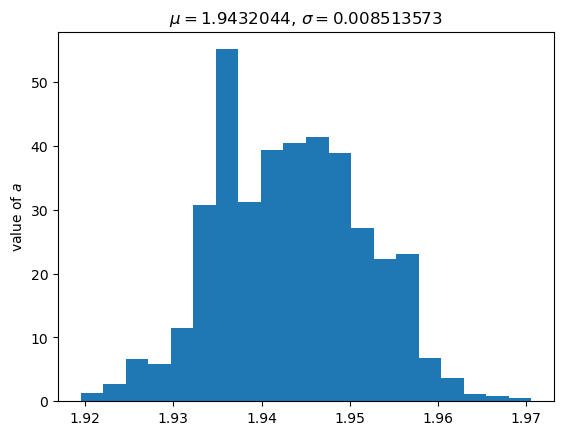

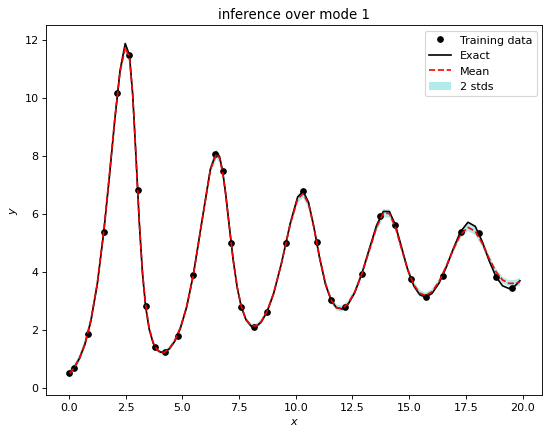

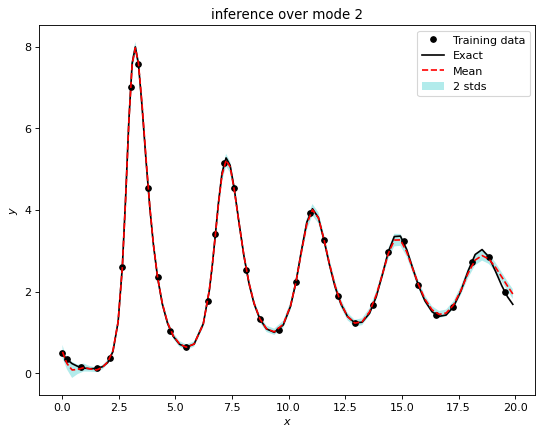

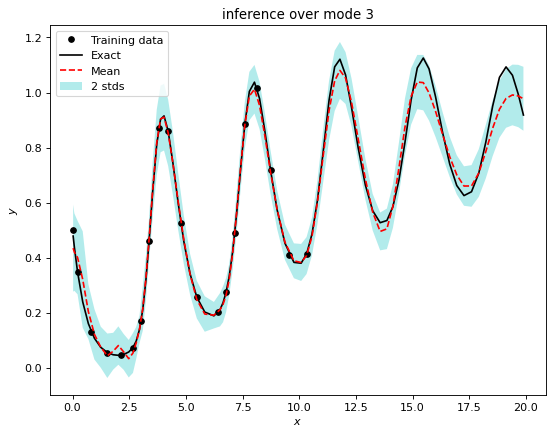

In [7]:
u_pred, a_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

In [8]:
############################### Choose framework #################################
#processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)


Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  20.628445
Iteration:  100 , loss:  8.102332
Iteration:  200 , loss:  7.6147785
Iteration:  300 , loss:  7.265986
Iteration:  400 , loss:  6.9607015
Iteration:  500 , loss:  6.6560946
Iteration:  600 , loss:  6.3292837
Iteration:  700 , loss:  5.9512677
Iteration:  800 , loss:  5.484419
Iteration:  900 , loss:  4.933884
Iteration:  1000 , loss:  4.340895
Iteration:  1100 , loss:  3.7604558
Iteration:  1200 , loss:  3.2493422
Iteration:  1300 , loss:  2.8139846
Iteration:  1400 , loss:  2.432823
Iteration:  1500 , loss:  2.1137073
Iteration:  1600 , loss:  1.8638904
Iteration:  1700 , loss:  1.6752958
Iteration:  1800 , loss:  1.5264411
Iteration:  1900 , loss:  1.3939936
Iteration:  2000 , loss:  1.2691433
Iteration:  2100 , loss:  1.1606596
Iteration:  2200 , loss:  1.0726908
Iteration:  2300 , loss:  0.99851435
Iteration:  2400 , loss:  0.9305248
Itera

Iteration:  1400 , loss:  1.9937265
Iteration:  1500 , loss:  1.777276
Iteration:  1600 , loss:  1.5789132
Iteration:  1700 , loss:  1.3910409
Iteration:  1800 , loss:  1.2198473
Iteration:  1900 , loss:  1.0660033
Iteration:  2000 , loss:  0.93619084
Iteration:  2100 , loss:  0.82544005
Iteration:  2200 , loss:  0.735371
Iteration:  2300 , loss:  0.66157913
Iteration:  2400 , loss:  0.5917544
Iteration:  2500 , loss:  0.5351419
Iteration:  2600 , loss:  0.50033045
Iteration:  2700 , loss:  0.47687885
Iteration:  2800 , loss:  0.45645636
Iteration:  2900 , loss:  0.43886214
Iteration:  3000 , loss:  0.42361736
Iteration:  3100 , loss:  0.4094151
Iteration:  3200 , loss:  0.39651695
Iteration:  3300 , loss:  0.38492006
Iteration:  3400 , loss:  0.3731487
Iteration:  3500 , loss:  0.3548739
Iteration:  3600 , loss:  0.330586
Iteration:  3700 , loss:  0.31149918
Iteration:  3800 , loss:  0.2953993
Iteration:  3900 , loss:  0.2797699
Iteration:  4000 , loss:  0.2619
Iteration:  4100 , loss

Iteration:  3200 , loss:  0.52295595
Iteration:  3300 , loss:  0.49785516
Iteration:  3400 , loss:  0.4786871
Iteration:  3500 , loss:  0.4626844
Iteration:  3600 , loss:  0.44855326
Iteration:  3700 , loss:  0.4351769
Iteration:  3800 , loss:  0.42120156
Iteration:  3900 , loss:  0.40388352
Iteration:  4000 , loss:  0.38244158
Iteration:  4100 , loss:  0.36019912
Iteration:  4200 , loss:  0.33710933
Iteration:  4300 , loss:  0.3118485
Iteration:  4400 , loss:  0.28869054
Iteration:  4500 , loss:  0.27155647
Iteration:  4600 , loss:  0.26000375
Iteration:  4700 , loss:  0.25111765
Iteration:  4800 , loss:  0.2444936
Iteration:  4900 , loss:  0.23839785
Iteration:  5000 , loss:  0.23231795
Iteration:  5100 , loss:  0.22606829
Iteration:  5200 , loss:  0.21984132
Iteration:  5300 , loss:  0.21385394
Iteration:  5400 , loss:  0.20793466
Iteration:  5500 , loss:  0.20039402
Iteration:  5600 , loss:  0.19148211
Iteration:  5700 , loss:  0.18568812
Iteration:  5800 , loss:  0.18126734
Iterat

Iteration:  5100 , loss:  0.18297406
Iteration:  5200 , loss:  0.17614704
Iteration:  5300 , loss:  0.16981965
Iteration:  5400 , loss:  0.16368699
Iteration:  5500 , loss:  0.15920913
Iteration:  5600 , loss:  0.15468943
Iteration:  5700 , loss:  0.15117696
Iteration:  5800 , loss:  0.14811908
Iteration:  5900 , loss:  0.14531736
Iteration:  6000 , loss:  0.14263164
Iteration:  6100 , loss:  0.13988844
Iteration:  6200 , loss:  0.13697089
Iteration:  6300 , loss:  0.13362323
Iteration:  6400 , loss:  0.12974113
Iteration:  6500 , loss:  0.12515172
Iteration:  6600 , loss:  0.120607466
Iteration:  6700 , loss:  0.11644138
Iteration:  6800 , loss:  0.11290105
Iteration:  6900 , loss:  0.10928605
Iteration:  7000 , loss:  0.10552568
Iteration:  7100 , loss:  0.100429974
Iteration:  7200 , loss:  0.094254814
Iteration:  7300 , loss:  0.08764573
Iteration:  7400 , loss:  0.08117102
Iteration:  7500 , loss:  0.075656846
Iteration:  7600 , loss:  0.07093082
Iteration:  7700 , loss:  0.067311

Iteration:  6700 , loss:  0.15674746
Iteration:  6800 , loss:  0.1523206
Iteration:  6900 , loss:  0.14828365
Iteration:  7000 , loss:  0.14450069
Iteration:  7100 , loss:  0.1401818
Iteration:  7200 , loss:  0.1337159
Iteration:  7300 , loss:  0.12940376
Iteration:  7400 , loss:  0.1262427
Iteration:  7500 , loss:  0.123255335
Iteration:  7600 , loss:  0.12016031
Iteration:  7700 , loss:  0.11673783
Iteration:  7800 , loss:  0.112992
Iteration:  7900 , loss:  0.10928937
Iteration:  8000 , loss:  0.10582193
Iteration:  8100 , loss:  0.10302576
Iteration:  8200 , loss:  0.10063499
Iteration:  8300 , loss:  0.09882074
Iteration:  8400 , loss:  0.0973195
Iteration:  8500 , loss:  0.09589954
Iteration:  8600 , loss:  0.08864744
Iteration:  8700 , loss:  0.08016858
Iteration:  8800 , loss:  0.07286416
Iteration:  8900 , loss:  0.06686124
Iteration:  9000 , loss:  0.06180972
Iteration:  9100 , loss:  0.057638157
Iteration:  9200 , loss:  0.054214604
Iteration:  9300 , loss:  0.05146655
Itera

Iteration:  8500 , loss:  0.114752755
Iteration:  8600 , loss:  0.11279487
Iteration:  8700 , loss:  0.11108234
Iteration:  8800 , loss:  0.108919755
Iteration:  8900 , loss:  0.10693819
Iteration:  9000 , loss:  0.105117194
Iteration:  9100 , loss:  0.103345335
Iteration:  9200 , loss:  0.10153589
Iteration:  9300 , loss:  0.099961735
Iteration:  9400 , loss:  0.09724832
Iteration:  9500 , loss:  0.094398394
Iteration:  9600 , loss:  0.09080263
Iteration:  9700 , loss:  0.08630768
Iteration:  9800 , loss:  0.08104895
Iteration:  9900 , loss:  0.07545451
Iteration:  10000 , loss:  0.07001525
Iteration:  10100 , loss:  0.06512412
Iteration:  10200 , loss:  0.06150453
Iteration:  10300 , loss:  0.057454675
Iteration:  10400 , loss:  0.055833444
Iteration:  10500 , loss:  0.05249578
Iteration:  10600 , loss:  0.050834022
Iteration:  10700 , loss:  0.049541045
Iteration:  10800 , loss:  0.0485486
Iteration:  10900 , loss:  0.04775759
Iteration:  11000 , loss:  0.047141567
Iteration:  11100

Iteration:  10300 , loss:  0.051746864
Iteration:  10400 , loss:  0.051137596
Iteration:  10500 , loss:  0.05052016
Iteration:  10600 , loss:  0.049904447
Iteration:  10700 , loss:  0.04927747
Iteration:  10800 , loss:  0.0486658
Iteration:  10900 , loss:  0.04803358
Iteration:  11000 , loss:  0.048250258
Iteration:  11100 , loss:  0.04678027
Iteration:  11200 , loss:  0.046139028
Iteration:  11300 , loss:  0.045501962
Iteration:  11400 , loss:  0.044853456
Iteration:  11500 , loss:  0.044201013
Iteration:  11600 , loss:  0.043535627
Iteration:  11700 , loss:  0.04298393
Iteration:  11800 , loss:  0.042181473
Iteration:  11900 , loss:  0.041480877
Iteration:  12000 , loss:  0.040771767
Iteration:  12100 , loss:  0.04003112
Iteration:  12200 , loss:  0.03930481
Iteration:  12300 , loss:  0.038512286
Iteration:  12400 , loss:  0.037923638
Iteration:  12500 , loss:  0.03690083
Iteration:  12600 , loss:  0.036040276
Iteration:  12700 , loss:  0.035149783
Iteration:  12800 , loss:  0.034211

Iteration:  11900 , loss:  0.017620414
Iteration:  12000 , loss:  0.017497996
Iteration:  12100 , loss:  0.017372455
Iteration:  12200 , loss:  0.017625956
Iteration:  12300 , loss:  0.017129261
Iteration:  12400 , loss:  0.01705401
Iteration:  12500 , loss:  0.016898405
Iteration:  12600 , loss:  0.016794102
Iteration:  12700 , loss:  0.01667579
Iteration:  12800 , loss:  0.01656948
Iteration:  12900 , loss:  0.01651081
Iteration:  13000 , loss:  0.01636195
Iteration:  13100 , loss:  0.016267553
Iteration:  13200 , loss:  0.01617461
Iteration:  13300 , loss:  0.01607506
Iteration:  13400 , loss:  0.015981803
Iteration:  13500 , loss:  0.016301855
Iteration:  13600 , loss:  0.015802236
Iteration:  13700 , loss:  0.01580383
Iteration:  13800 , loss:  0.01563297
Iteration:  13900 , loss:  0.016039465
Iteration:  14000 , loss:  0.015470526
Iteration:  14100 , loss:  0.015500844
Iteration:  14200 , loss:  0.0154018635
Iteration:  14300 , loss:  0.015253688
Iteration:  14400 , loss:  0.0151

Iteration:  13600 , loss:  0.011521307
Iteration:  13700 , loss:  0.011356675
Iteration:  13800 , loss:  0.011177322
Iteration:  13900 , loss:  0.010992285
Iteration:  14000 , loss:  0.0108582685
Iteration:  14100 , loss:  0.010599675
Iteration:  14200 , loss:  0.010335803
Iteration:  14300 , loss:  0.010074852
Iteration:  14400 , loss:  0.010022025
Iteration:  14500 , loss:  0.0095292395
Iteration:  14600 , loss:  0.009289593
Iteration:  14700 , loss:  0.009066314
Iteration:  14800 , loss:  0.008914778
Iteration:  14900 , loss:  0.008668929
Iteration:  15000 , loss:  0.008488247
Iteration:  15100 , loss:  0.008308016
Iteration:  15200 , loss:  0.008130375
Iteration:  15300 , loss:  0.007949536
Iteration:  15400 , loss:  0.007772154
Iteration:  15500 , loss:  0.0076110354
Iteration:  15600 , loss:  0.007418321
Iteration:  15700 , loss:  0.0072475113
Iteration:  15800 , loss:  0.0070839957
Iteration:  15900 , loss:  0.00693452
Iteration:  16000 , loss:  0.006772611
Iteration:  16100 , l

Iteration:  15300 , loss:  0.0062769973
Iteration:  15400 , loss:  0.006201596
Iteration:  15500 , loss:  0.006112427
Iteration:  15600 , loss:  0.0060341684
Iteration:  15700 , loss:  0.005959699
Iteration:  15800 , loss:  0.0058933673
Iteration:  15900 , loss:  0.005948377
Iteration:  16000 , loss:  0.005748769
Iteration:  16100 , loss:  0.005688652
Iteration:  16200 , loss:  0.0056248293
Iteration:  16300 , loss:  0.005567155
Iteration:  16400 , loss:  0.0054968125
Iteration:  16500 , loss:  0.0054414826
Iteration:  16600 , loss:  0.005381844
Iteration:  16700 , loss:  0.00532696
Iteration:  16800 , loss:  0.0052740285
Iteration:  16900 , loss:  0.007051218
Iteration:  17000 , loss:  0.005170775
Iteration:  17100 , loss:  0.0053030695
Iteration:  17200 , loss:  0.0050784317
Iteration:  17300 , loss:  0.005131764
Iteration:  17400 , loss:  0.0049807425
Iteration:  17500 , loss:  0.0049376306
Iteration:  17600 , loss:  0.0048935786
Iteration:  17700 , loss:  0.0048506153
Iteration:  1

Iteration:  16900 , loss:  0.005174512
Iteration:  17000 , loss:  0.0049906867
Iteration:  17100 , loss:  0.005047808
Iteration:  17200 , loss:  0.0047989297
Iteration:  17300 , loss:  0.004711551
Iteration:  17400 , loss:  0.0047030365
Iteration:  17500 , loss:  0.004556575
Iteration:  17600 , loss:  0.004485221
Iteration:  17700 , loss:  0.004446452
Iteration:  17800 , loss:  0.004355449
Iteration:  17900 , loss:  0.004302867
Iteration:  18000 , loss:  0.004233758
Iteration:  18100 , loss:  0.004613786
Iteration:  18200 , loss:  0.0041258396
Iteration:  18300 , loss:  0.004075247
Iteration:  18400 , loss:  0.0040274686
Iteration:  18500 , loss:  0.0039806636
Iteration:  18600 , loss:  0.003950127
Iteration:  18700 , loss:  0.003895984
Iteration:  18800 , loss:  0.0038599386
Iteration:  18900 , loss:  0.0038157117
Iteration:  19000 , loss:  0.0037853678
Iteration:  19100 , loss:  0.0037405335
Iteration:  19200 , loss:  0.0037034666
Iteration:  19300 , loss:  0.0036861785
Iteration:  1

Iteration:  18400 , loss:  0.0027071738
Iteration:  18500 , loss:  0.0026599192
Iteration:  18600 , loss:  0.0026583467
Iteration:  18700 , loss:  0.0026272747
Iteration:  18800 , loss:  0.0027788458
Iteration:  18900 , loss:  0.002593242
Iteration:  19000 , loss:  0.0025950514
Iteration:  19100 , loss:  0.0025630577
Iteration:  19200 , loss:  0.002549691
Iteration:  19300 , loss:  0.0025299017
Iteration:  19400 , loss:  0.0025852842
Iteration:  19500 , loss:  0.002549324
Iteration:  19600 , loss:  0.0026419242
Iteration:  19700 , loss:  0.002475191
Iteration:  19800 , loss:  0.0024690165
Iteration:  19900 , loss:  0.0025035583
Generating 12th sample by deep ensemble...
Iteration:  0 , loss:  14.482852
Iteration:  100 , loss:  7.9823575
Iteration:  200 , loss:  7.535571
Iteration:  300 , loss:  7.2009797
Iteration:  400 , loss:  6.876331
Iteration:  500 , loss:  6.52622
Iteration:  600 , loss:  6.1174655
Iteration:  700 , loss:  5.6189866
Iteration:  800 , loss:  5.031893
Iteration:  9

Iteration:  0 , loss:  15.367334
Iteration:  100 , loss:  8.079263
Iteration:  200 , loss:  7.624824
Iteration:  300 , loss:  7.290878
Iteration:  400 , loss:  6.987324
Iteration:  500 , loss:  6.6785
Iteration:  600 , loss:  6.3239007
Iteration:  700 , loss:  5.8669844
Iteration:  800 , loss:  5.3088675
Iteration:  900 , loss:  4.7013636
Iteration:  1000 , loss:  4.0762486
Iteration:  1100 , loss:  3.4471803
Iteration:  1200 , loss:  2.8950806
Iteration:  1300 , loss:  2.479989
Iteration:  1400 , loss:  2.1751883
Iteration:  1500 , loss:  1.9311287
Iteration:  1600 , loss:  1.7309158
Iteration:  1700 , loss:  1.5539215
Iteration:  1800 , loss:  1.3865756
Iteration:  1900 , loss:  1.2415651
Iteration:  2000 , loss:  1.1213489
Iteration:  2100 , loss:  1.0151023
Iteration:  2200 , loss:  0.91589665
Iteration:  2300 , loss:  0.8267365
Iteration:  2400 , loss:  0.74786955
Iteration:  2500 , loss:  0.6781859
Iteration:  2600 , loss:  0.6196444
Iteration:  2700 , loss:  0.5744401
Iteration:

Iteration:  1900 , loss:  1.2865919
Iteration:  2000 , loss:  1.1436429
Iteration:  2100 , loss:  1.0040237
Iteration:  2200 , loss:  0.8772719
Iteration:  2300 , loss:  0.7695193
Iteration:  2400 , loss:  0.69014925
Iteration:  2500 , loss:  0.6211029
Iteration:  2600 , loss:  0.57237697
Iteration:  2700 , loss:  0.5380344
Iteration:  2800 , loss:  0.5112413
Iteration:  2900 , loss:  0.48714122
Iteration:  3000 , loss:  0.46203986
Iteration:  3100 , loss:  0.43773302
Iteration:  3200 , loss:  0.41778985
Iteration:  3300 , loss:  0.40253994
Iteration:  3400 , loss:  0.38935506
Iteration:  3500 , loss:  0.37437302
Iteration:  3600 , loss:  0.3596607
Iteration:  3700 , loss:  0.3461323
Iteration:  3800 , loss:  0.33456147
Iteration:  3900 , loss:  0.3239551
Iteration:  4000 , loss:  0.3121037
Iteration:  4100 , loss:  0.29748964
Iteration:  4200 , loss:  0.28242987
Iteration:  4300 , loss:  0.2696925
Iteration:  4400 , loss:  0.25892138
Iteration:  4500 , loss:  0.24761368
Iteration:  46

Iteration:  3700 , loss:  0.3192249
Iteration:  3800 , loss:  0.29974887
Iteration:  3900 , loss:  0.28449023
Iteration:  4000 , loss:  0.27268898
Iteration:  4100 , loss:  0.26219398
Iteration:  4200 , loss:  0.25431174
Iteration:  4300 , loss:  0.24823134
Iteration:  4400 , loss:  0.24266408
Iteration:  4500 , loss:  0.23771991
Iteration:  4600 , loss:  0.23296662
Iteration:  4700 , loss:  0.22813553
Iteration:  4800 , loss:  0.22312143
Iteration:  4900 , loss:  0.21757075
Iteration:  5000 , loss:  0.2117294
Iteration:  5100 , loss:  0.205631
Iteration:  5200 , loss:  0.19928207
Iteration:  5300 , loss:  0.1924014
Iteration:  5400 , loss:  0.18475336
Iteration:  5500 , loss:  0.17708321
Iteration:  5600 , loss:  0.17025636
Iteration:  5700 , loss:  0.16428462
Iteration:  5800 , loss:  0.15997222
Iteration:  5900 , loss:  0.150668
Iteration:  6000 , loss:  0.14411679
Iteration:  6100 , loss:  0.13955723
Iteration:  6200 , loss:  0.13554291
Iteration:  6300 , loss:  0.13135062
Iteratio

Iteration:  5300 , loss:  0.14509183
Iteration:  5400 , loss:  0.13758023
Iteration:  5500 , loss:  0.13286276
Iteration:  5600 , loss:  0.12570684
Iteration:  5700 , loss:  0.12054667
Iteration:  5800 , loss:  0.117038175
Iteration:  5900 , loss:  0.11607129
Iteration:  6000 , loss:  0.11206266
Iteration:  6100 , loss:  0.11008085
Iteration:  6200 , loss:  0.108279675
Iteration:  6300 , loss:  0.10663525
Iteration:  6400 , loss:  0.105112806
Iteration:  6500 , loss:  0.10365054
Iteration:  6600 , loss:  0.10213513
Iteration:  6700 , loss:  0.10024738
Iteration:  6800 , loss:  0.09736477
Iteration:  6900 , loss:  0.08594209
Iteration:  7000 , loss:  0.0726771
Iteration:  7100 , loss:  0.063299224
Iteration:  7200 , loss:  0.056973528
Iteration:  7300 , loss:  0.05218697
Iteration:  7400 , loss:  0.04769732
Iteration:  7500 , loss:  0.043501392
Iteration:  7600 , loss:  0.039435986
Iteration:  7700 , loss:  0.036042444
Iteration:  7800 , loss:  0.03316209
Iteration:  7900 , loss:  0.030

Iteration:  6800 , loss:  0.12101848
Iteration:  6900 , loss:  0.116842285
Iteration:  7000 , loss:  0.11255012
Iteration:  7100 , loss:  0.10738256
Iteration:  7200 , loss:  0.10125527
Iteration:  7300 , loss:  0.09447051
Iteration:  7400 , loss:  0.08794105
Iteration:  7500 , loss:  0.08281975
Iteration:  7600 , loss:  0.07908657
Iteration:  7700 , loss:  0.07606252
Iteration:  7800 , loss:  0.07336424
Iteration:  7900 , loss:  0.07346398
Iteration:  8000 , loss:  0.06792066
Iteration:  8100 , loss:  0.065173
Iteration:  8200 , loss:  0.062216725
Iteration:  8300 , loss:  0.059269257
Iteration:  8400 , loss:  0.05638313
Iteration:  8500 , loss:  0.0537134
Iteration:  8600 , loss:  0.05118058
Iteration:  8700 , loss:  0.048852332
Iteration:  8800 , loss:  0.04656933
Iteration:  8900 , loss:  0.044497415
Iteration:  9000 , loss:  0.042444643
Iteration:  9100 , loss:  0.04055057
Iteration:  9200 , loss:  0.038620844
Iteration:  9300 , loss:  0.036838647
Iteration:  9400 , loss:  0.03516

Iteration:  8500 , loss:  0.09205506
Iteration:  8600 , loss:  0.09109514
Iteration:  8700 , loss:  0.09041326
Iteration:  8800 , loss:  0.08901203
Iteration:  8900 , loss:  0.08787044
Iteration:  9000 , loss:  0.08650501
Iteration:  9100 , loss:  0.08503969
Iteration:  9200 , loss:  0.08343926
Iteration:  9300 , loss:  0.081674874
Iteration:  9400 , loss:  0.07959069
Iteration:  9500 , loss:  0.07716556
Iteration:  9600 , loss:  0.074208885
Iteration:  9700 , loss:  0.07072344
Iteration:  9800 , loss:  0.0667558
Iteration:  9900 , loss:  0.062582485
Iteration:  10000 , loss:  0.058706854
Iteration:  10100 , loss:  0.054624796
Iteration:  10200 , loss:  0.05117051
Iteration:  10300 , loss:  0.048311528
Iteration:  10400 , loss:  0.045947745
Iteration:  10500 , loss:  0.044088602
Iteration:  10600 , loss:  0.042593077
Iteration:  10700 , loss:  0.04140051
Iteration:  10800 , loss:  0.04031666
Iteration:  10900 , loss:  0.03932698
Iteration:  11000 , loss:  0.038152292
Iteration:  11100 

Iteration:  10400 , loss:  0.07005835
Iteration:  10500 , loss:  0.06792553
Iteration:  10600 , loss:  0.065238394
Iteration:  10700 , loss:  0.062795825
Iteration:  10800 , loss:  0.06048558
Iteration:  10900 , loss:  0.058781624
Iteration:  11000 , loss:  0.056596007
Iteration:  11100 , loss:  0.054389186
Iteration:  11200 , loss:  0.05264757
Iteration:  11300 , loss:  0.05108466
Iteration:  11400 , loss:  0.049637355
Iteration:  11500 , loss:  0.0492698
Iteration:  11600 , loss:  0.048118573
Iteration:  11700 , loss:  0.04568823
Iteration:  11800 , loss:  0.044548143
Iteration:  11900 , loss:  0.04346438
Iteration:  12000 , loss:  0.04315425
Iteration:  12100 , loss:  0.041456617
Iteration:  12200 , loss:  0.040536195
Iteration:  12300 , loss:  0.039708808
Iteration:  12400 , loss:  0.039131526
Iteration:  12500 , loss:  0.038389336
Iteration:  12600 , loss:  0.037253674
Iteration:  12700 , loss:  0.0364875
Iteration:  12800 , loss:  0.03567394
Iteration:  12900 , loss:  0.034748707

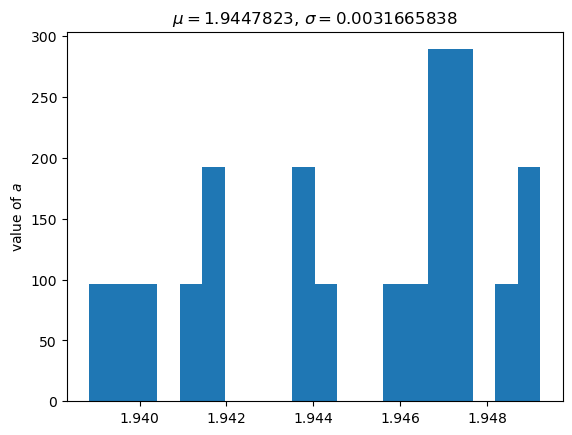

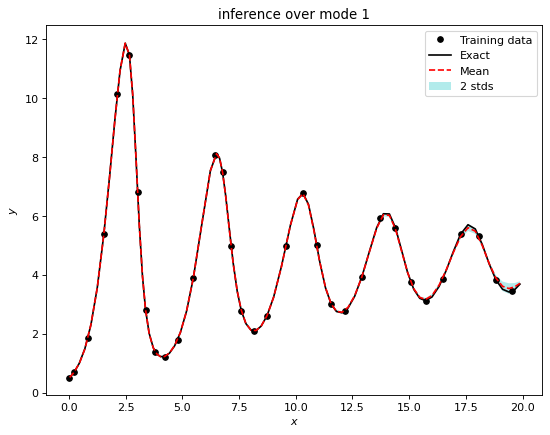

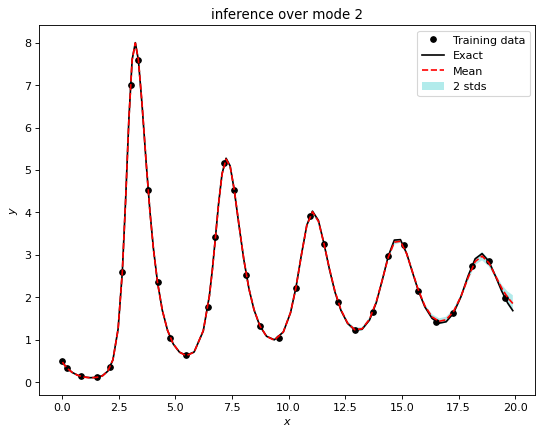

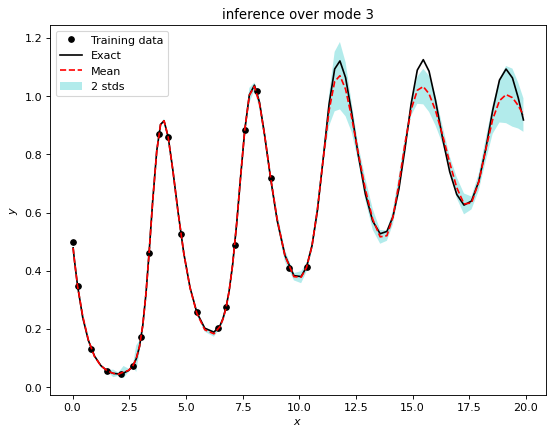

In [9]:
u_pred, a_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

# 3 parameters estimation (missing data u3)

In [16]:
def ode3_fn(t, u, mu, r1, r2, r3):
    
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t, u2_t, u3_t = tf.gradients(u1,t)[0], tf.gradients(u2,t)[0], tf.gradients(u3,t)[0]
    
    f1 = u1_t - u1*(mu - 0.1*u1 - r1*u2 - r2*u3)
    f2 = u2_t - u2*(-mu + 0.5*u1 - r3*u3)
    f3 = u3_t - u3*(-mu + 0.2*u1 + 0.5*u2)
    
    return tf.concat([f1,f2, f3], axis=-1)

In [17]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:20]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=3, sigma=2),
    )
    process_mu = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=1, sigma=1),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
        sigma=noise,
    )
    likelihood_u3 = neuq.likelihoods.Normal(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
        sigma=noise,
    )
    
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        pde=ode3_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=2000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))
    
    processes = [process_u, process_mu, process_r1, process_r2, process_r3]

    return processes, samples, model

@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:20]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_mu = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
    )
    likelihood_u3 = neuq.likelihoods.MSE(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
    )
    
    likelihood_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        pde=ode3_fn,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_mu, process_r1, process_r2, process_r3]
    return processes, samples, model

################## Load data and specify some hyperparameters ####################
t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test = load_data_inv()

layers = [1, 50, 50, 3]

In [18]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u2_train = u_train[:,0:1], u_train[:,1:2]  # training data
    t_u3_train = t_u_train[:20]
    u3_train = u_train[:20, 2:3]

    neuq.utils.hist(mu_pred, name="value of $mu$")
    neuq.utils.hist(r1_pred, name=r"value of $\theta_{11}$")
    neuq.utils.hist(r2_pred, name=r"value of $\theta_{12}$")
    neuq.utils.hist(r3_pred, name=r"value of $\theta_{21}$")
    
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_u_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
    )
    neuq.utils.plot1d(
        t_u3_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
    )

In [19]:
############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

#processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.536 

Execution time for 'Samplable' function is: 357.958 s, 5.966 mins


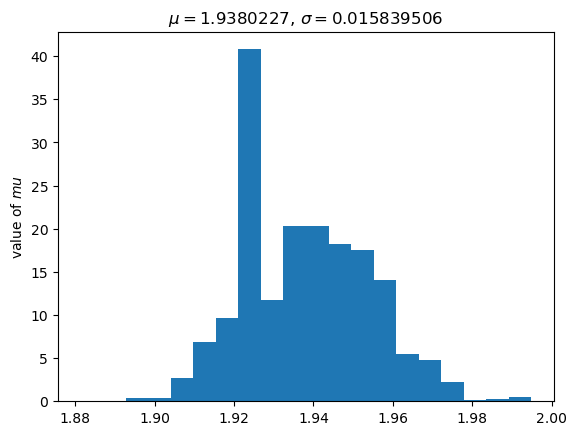

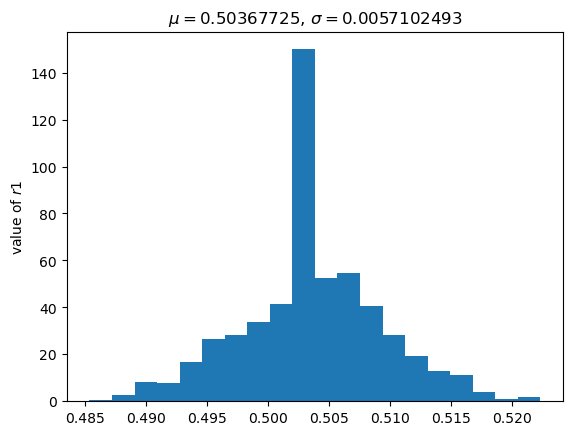

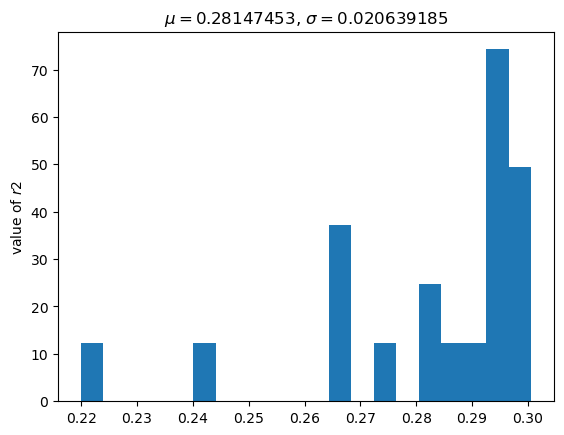

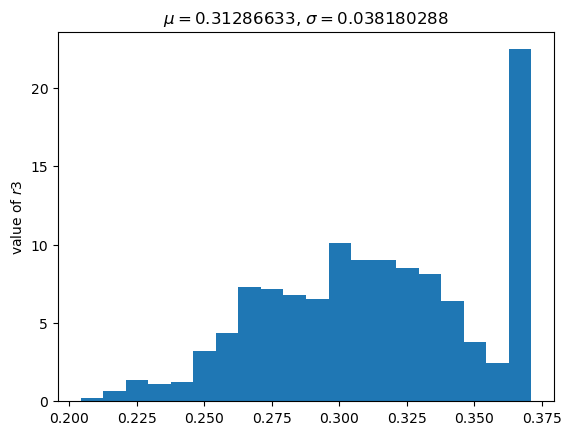

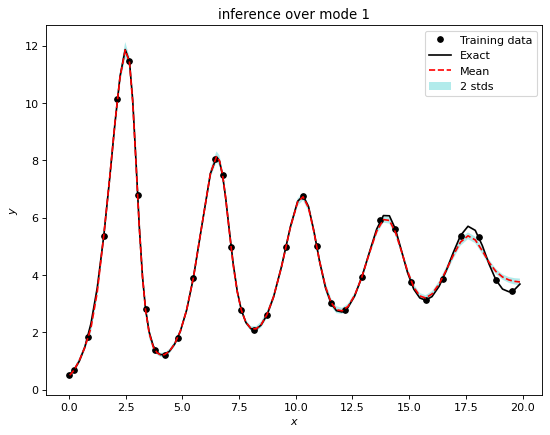

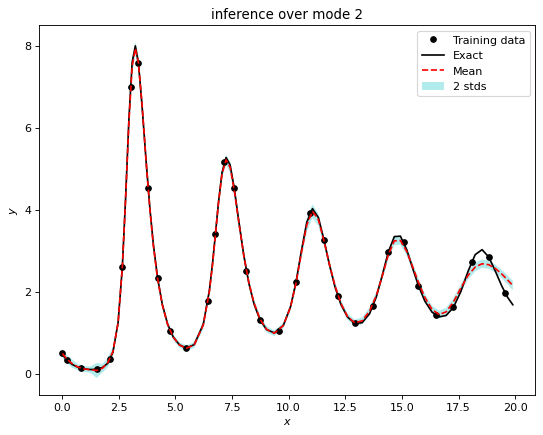

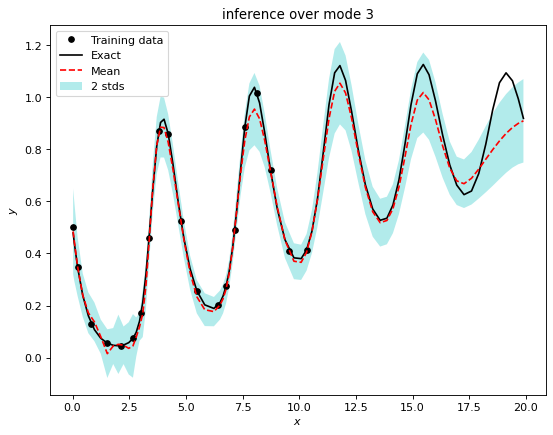

In [20]:
u_pred, mu_pred, r1_pred, r2_predt, r3_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

In [21]:
############################### Choose framework #################################
#processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  13.299657
Iteration:  100 , loss:  6.8409905
Iteration:  200 , loss:  6.5118237
Iteration:  300 , loss:  6.385396
Iteration:  400 , loss:  6.2706285
Iteration:  500 , loss:  6.082566
Iteration:  600 , loss:  5.6673827
Iteration:  700 , loss:  4.9959803
Iteration:  800 , loss:  4.3055687
Iteration:  900 , loss:  3.6800973
Iteration:  1000 , loss:  3.106703
Iteration:  1100 , loss:  2.6112297
Iteration:  1200 , loss:  2.2265196
Iteration:  1300 , loss:  1.959682
Iteration:  1400 , loss:  1.7707888
Iteration:  1500 , loss:  1.6161015
Iteration:  1600 , loss:  1.4834541
Iteration:  1700 , loss:  1.370399
Iteration:  1800 , loss:  1.2788293
Iteration:  1900 , loss:  1.1896473
Iteration:  2000 , loss:  1.090953
Iteration:  2100 , loss:  0.98271877
Iteration:  2200 , loss:  0.881196
Iteration:  2300 , loss:  0.79958177
Iteration:  2400 , loss:  0.7366243
Itera

Iteration:  1400 , loss:  1.7415762
Iteration:  1500 , loss:  1.5875448
Iteration:  1600 , loss:  1.4472077
Iteration:  1700 , loss:  1.3219156
Iteration:  1800 , loss:  1.2118435
Iteration:  1900 , loss:  1.119994
Iteration:  2000 , loss:  1.0397378
Iteration:  2100 , loss:  0.9517479
Iteration:  2200 , loss:  0.86259055
Iteration:  2300 , loss:  0.7918505
Iteration:  2400 , loss:  0.73889345
Iteration:  2500 , loss:  0.69493514
Iteration:  2600 , loss:  0.65462446
Iteration:  2700 , loss:  0.6152453
Iteration:  2800 , loss:  0.5830176
Iteration:  2900 , loss:  0.5555781
Iteration:  3000 , loss:  0.5301932
Iteration:  3100 , loss:  0.5103598
Iteration:  3200 , loss:  0.4929402
Iteration:  3300 , loss:  0.47236997
Iteration:  3400 , loss:  0.44829053
Iteration:  3500 , loss:  0.4218685
Iteration:  3600 , loss:  0.39365298
Iteration:  3700 , loss:  0.36761168
Iteration:  3800 , loss:  0.34523025
Iteration:  3900 , loss:  0.32621303
Iteration:  4000 , loss:  0.30924392
Iteration:  4100 ,

Iteration:  3200 , loss:  0.524078
Iteration:  3300 , loss:  0.5104626
Iteration:  3400 , loss:  0.49890366
Iteration:  3500 , loss:  0.48816088
Iteration:  3600 , loss:  0.47723952
Iteration:  3700 , loss:  0.4655366
Iteration:  3800 , loss:  0.4519619
Iteration:  3900 , loss:  0.43503517
Iteration:  4000 , loss:  0.41852126
Iteration:  4100 , loss:  0.40261278
Iteration:  4200 , loss:  0.38352475
Iteration:  4300 , loss:  0.36242703
Iteration:  4400 , loss:  0.33744296
Iteration:  4500 , loss:  0.3109168
Iteration:  4600 , loss:  0.28791592
Iteration:  4700 , loss:  0.26899964
Iteration:  4800 , loss:  0.25161612
Iteration:  4900 , loss:  0.23731044
Iteration:  5000 , loss:  0.227038
Iteration:  5100 , loss:  0.21895373
Iteration:  5200 , loss:  0.21104746
Iteration:  5300 , loss:  0.20236754
Iteration:  5400 , loss:  0.19207047
Iteration:  5500 , loss:  0.18525515
Iteration:  5600 , loss:  0.18005612
Iteration:  5700 , loss:  0.17624854
Iteration:  5800 , loss:  0.17161974
Iteration

Iteration:  5000 , loss:  0.29186565
Iteration:  5100 , loss:  0.28230605
Iteration:  5200 , loss:  0.2740413
Iteration:  5300 , loss:  0.2661715
Iteration:  5400 , loss:  0.25745496
Iteration:  5500 , loss:  0.24861985
Iteration:  5600 , loss:  0.24136195
Iteration:  5700 , loss:  0.23599194
Iteration:  5800 , loss:  0.2323725
Iteration:  5900 , loss:  0.22950844
Iteration:  6000 , loss:  0.22756988
Iteration:  6100 , loss:  0.22614229
Iteration:  6200 , loss:  0.2192518
Iteration:  6300 , loss:  0.21381822
Iteration:  6400 , loss:  0.20873566
Iteration:  6500 , loss:  0.20359461
Iteration:  6600 , loss:  0.19834557
Iteration:  6700 , loss:  0.19234258
Iteration:  6800 , loss:  0.18527663
Iteration:  6900 , loss:  0.17843442
Iteration:  7000 , loss:  0.17319767
Iteration:  7100 , loss:  0.16969739
Iteration:  7200 , loss:  0.16719997
Iteration:  7300 , loss:  0.16548929
Iteration:  7400 , loss:  0.16417538
Iteration:  7500 , loss:  0.16308264
Iteration:  7600 , loss:  0.16214034
Itera

Iteration:  6900 , loss:  0.18451385
Iteration:  7000 , loss:  0.1770663
Iteration:  7100 , loss:  0.1686378
Iteration:  7200 , loss:  0.16060445
Iteration:  7300 , loss:  0.15378755
Iteration:  7400 , loss:  0.14819881
Iteration:  7500 , loss:  0.14382048
Iteration:  7600 , loss:  0.13926281
Iteration:  7700 , loss:  0.14192007
Iteration:  7800 , loss:  0.13071258
Iteration:  7900 , loss:  0.12514102
Iteration:  8000 , loss:  0.12010387
Iteration:  8100 , loss:  0.116067044
Iteration:  8200 , loss:  0.11303066
Iteration:  8300 , loss:  0.11072654
Iteration:  8400 , loss:  0.10887599
Iteration:  8500 , loss:  0.10737927
Iteration:  8600 , loss:  0.106096566
Iteration:  8700 , loss:  0.10490926
Iteration:  8800 , loss:  0.10319409
Iteration:  8900 , loss:  0.09989123
Iteration:  9000 , loss:  0.09570919
Iteration:  9100 , loss:  0.08947114
Iteration:  9200 , loss:  0.08248428
Iteration:  9300 , loss:  0.07631807
Iteration:  9400 , loss:  0.069935426
Iteration:  9500 , loss:  0.06520822


Iteration:  8700 , loss:  0.080865994
Iteration:  8800 , loss:  0.07103573
Iteration:  8900 , loss:  0.06516573
Iteration:  9000 , loss:  0.0586879
Iteration:  9100 , loss:  0.05504499
Iteration:  9200 , loss:  0.05238895
Iteration:  9300 , loss:  0.05027601
Iteration:  9400 , loss:  0.048596554
Iteration:  9500 , loss:  0.047180843
Iteration:  9600 , loss:  0.04635336
Iteration:  9700 , loss:  0.04483727
Iteration:  9800 , loss:  0.04374228
Iteration:  9900 , loss:  0.04229981
Iteration:  10000 , loss:  0.041077513
Iteration:  10100 , loss:  0.039532978
Iteration:  10200 , loss:  0.03805519
Iteration:  10300 , loss:  0.036348093
Iteration:  10400 , loss:  0.035492077
Iteration:  10500 , loss:  0.032644708
Iteration:  10600 , loss:  0.030519476
Iteration:  10700 , loss:  0.028676158
Iteration:  10800 , loss:  0.030236024
Iteration:  10900 , loss:  0.025509328
Iteration:  11000 , loss:  0.024169298
Iteration:  11100 , loss:  0.022939246
Iteration:  11200 , loss:  0.021848867
Iteration: 

Iteration:  10400 , loss:  0.03800825
Iteration:  10500 , loss:  0.036176194
Iteration:  10600 , loss:  0.033820078
Iteration:  10700 , loss:  0.03209008
Iteration:  10800 , loss:  0.031212876
Iteration:  10900 , loss:  0.029015379
Iteration:  11000 , loss:  0.027596151
Iteration:  11100 , loss:  0.02642325
Iteration:  11200 , loss:  0.025340179
Iteration:  11300 , loss:  0.024933072
Iteration:  11400 , loss:  0.023175096
Iteration:  11500 , loss:  0.022363428
Iteration:  11600 , loss:  0.021645855
Iteration:  11700 , loss:  0.021022769
Iteration:  11800 , loss:  0.021071427
Iteration:  11900 , loss:  0.02001106
Iteration:  12000 , loss:  0.019612307
Iteration:  12100 , loss:  0.019249838
Iteration:  12200 , loss:  0.019721052
Iteration:  12300 , loss:  0.019511305
Iteration:  12400 , loss:  0.018387116
Iteration:  12500 , loss:  0.018147968
Iteration:  12600 , loss:  0.01794388
Iteration:  12700 , loss:  0.01772531
Iteration:  12800 , loss:  0.017532075
Iteration:  12900 , loss:  0.01

Iteration:  12100 , loss:  0.020762319
Iteration:  12200 , loss:  0.01919303
Iteration:  12300 , loss:  0.01780683
Iteration:  12400 , loss:  0.0165441
Iteration:  12500 , loss:  0.016122604
Iteration:  12600 , loss:  0.014505614
Iteration:  12700 , loss:  0.01372347
Iteration:  12800 , loss:  0.013111335
Iteration:  12900 , loss:  0.012646929
Iteration:  13000 , loss:  0.012291573
Iteration:  13100 , loss:  0.0120238215
Iteration:  13200 , loss:  0.011791456
Iteration:  13300 , loss:  0.011598258
Iteration:  13400 , loss:  0.011427897
Iteration:  13500 , loss:  0.011251111
Iteration:  13600 , loss:  0.01108706
Iteration:  13700 , loss:  0.010930054
Iteration:  13800 , loss:  0.011998469
Iteration:  13900 , loss:  0.010631157
Iteration:  14000 , loss:  0.010535182
Iteration:  14100 , loss:  0.011126255
Iteration:  14200 , loss:  0.010162811
Iteration:  14300 , loss:  0.010016394
Iteration:  14400 , loss:  0.009867082
Iteration:  14500 , loss:  0.009741769
Iteration:  14600 , loss:  0.0

Iteration:  13800 , loss:  0.04231974
Iteration:  13900 , loss:  0.04222865
Iteration:  14000 , loss:  0.042096537
Iteration:  14100 , loss:  0.041987482
Iteration:  14200 , loss:  0.041983694
Iteration:  14300 , loss:  0.0418052
Iteration:  14400 , loss:  0.041929755
Iteration:  14500 , loss:  0.04155953
Iteration:  14600 , loss:  0.04146916
Iteration:  14700 , loss:  0.04136689
Iteration:  14800 , loss:  0.041268066
Iteration:  14900 , loss:  0.04117318
Iteration:  15000 , loss:  0.041081045
Iteration:  15100 , loss:  0.04101202
Iteration:  15200 , loss:  0.04112724
Iteration:  15300 , loss:  0.040819135
Iteration:  15400 , loss:  0.04072878
Iteration:  15500 , loss:  0.04064365
Iteration:  15600 , loss:  0.040561832
Iteration:  15700 , loss:  0.04050769
Iteration:  15800 , loss:  0.041135643
Iteration:  15900 , loss:  0.040337197
Iteration:  16000 , loss:  0.040376905
Iteration:  16100 , loss:  0.040626224
Iteration:  16200 , loss:  0.040111084
Iteration:  16300 , loss:  0.04026344


Iteration:  15600 , loss:  0.08191163
Iteration:  15700 , loss:  0.08164244
Iteration:  15800 , loss:  0.081180334
Iteration:  15900 , loss:  0.08107076
Iteration:  16000 , loss:  0.08101259
Iteration:  16100 , loss:  0.08102995
Iteration:  16200 , loss:  0.0812518
Iteration:  16300 , loss:  0.08100368
Iteration:  16400 , loss:  0.08080608
Iteration:  16500 , loss:  0.0807656
Iteration:  16600 , loss:  0.08072249
Iteration:  16700 , loss:  0.081163004
Iteration:  16800 , loss:  0.08064227
Iteration:  16900 , loss:  0.08060355
Iteration:  17000 , loss:  0.08056512
Iteration:  17100 , loss:  0.080931254
Iteration:  17200 , loss:  0.081303366
Iteration:  17300 , loss:  0.066808335
Iteration:  17400 , loss:  0.057051953
Iteration:  17500 , loss:  0.051193167
Iteration:  17600 , loss:  0.047928624
Iteration:  17700 , loss:  0.04592984
Iteration:  17800 , loss:  0.04462326
Iteration:  17900 , loss:  0.043784317
Iteration:  18000 , loss:  0.04312311
Iteration:  18100 , loss:  0.04269463
Itera

Iteration:  17300 , loss:  0.018603954
Iteration:  17400 , loss:  0.01930014
Iteration:  17500 , loss:  0.017773423
Iteration:  17600 , loss:  0.017397324
Iteration:  17700 , loss:  0.017088752
Iteration:  17800 , loss:  0.016814921
Iteration:  17900 , loss:  0.016485965
Iteration:  18000 , loss:  0.01618255
Iteration:  18100 , loss:  0.015907956
Iteration:  18200 , loss:  0.015788399
Iteration:  18300 , loss:  0.015383852
Iteration:  18400 , loss:  0.015146462
Iteration:  18500 , loss:  0.014929027
Iteration:  18600 , loss:  0.014688298
Iteration:  18700 , loss:  0.014500875
Iteration:  18800 , loss:  0.015576277
Iteration:  18900 , loss:  0.0141110085
Iteration:  19000 , loss:  0.013917148
Iteration:  19100 , loss:  0.013748506
Iteration:  19200 , loss:  0.01402921
Iteration:  19300 , loss:  0.013470202
Iteration:  19400 , loss:  0.014205802
Iteration:  19500 , loss:  0.013202841
Iteration:  19600 , loss:  0.013313717
Iteration:  19700 , loss:  0.012925083
Iteration:  19800 , loss:  

Iteration:  18700 , loss:  0.0052130413
Iteration:  18800 , loss:  0.002914066
Iteration:  18900 , loss:  0.0029015085
Iteration:  19000 , loss:  0.0028981508
Iteration:  19100 , loss:  0.0032915166
Iteration:  19200 , loss:  0.003030505
Iteration:  19300 , loss:  0.0030144928
Iteration:  19400 , loss:  0.0028253854
Iteration:  19500 , loss:  0.0028303731
Iteration:  19600 , loss:  0.0027996849
Iteration:  19700 , loss:  0.002826094
Iteration:  19800 , loss:  0.0032653983
Iteration:  19900 , loss:  0.0027517672
Generating 12th sample by deep ensemble...
Iteration:  0 , loss:  23.447107
Iteration:  100 , loss:  7.0276084
Iteration:  200 , loss:  6.5856338
Iteration:  300 , loss:  6.4517264
Iteration:  400 , loss:  6.350051
Iteration:  500 , loss:  6.200925
Iteration:  600 , loss:  5.890233
Iteration:  700 , loss:  5.3439813
Iteration:  800 , loss:  4.6965766
Iteration:  900 , loss:  4.0379305
Iteration:  1000 , loss:  3.448898
Iteration:  1100 , loss:  2.9469573
Iteration:  1200 , loss:

Iteration:  200 , loss:  6.5055757
Iteration:  300 , loss:  6.361899
Iteration:  400 , loss:  6.2367277
Iteration:  500 , loss:  6.0296946
Iteration:  600 , loss:  5.5968437
Iteration:  700 , loss:  4.9845605
Iteration:  800 , loss:  4.354205
Iteration:  900 , loss:  3.731847
Iteration:  1000 , loss:  3.1585324
Iteration:  1100 , loss:  2.6634777
Iteration:  1200 , loss:  2.287741
Iteration:  1300 , loss:  2.00468
Iteration:  1400 , loss:  1.7771282
Iteration:  1500 , loss:  1.598839
Iteration:  1600 , loss:  1.4612801
Iteration:  1700 , loss:  1.3568232
Iteration:  1800 , loss:  1.2718928
Iteration:  1900 , loss:  1.1898255
Iteration:  2000 , loss:  1.1051564
Iteration:  2100 , loss:  1.0201871
Iteration:  2200 , loss:  0.9356105
Iteration:  2300 , loss:  0.8542051
Iteration:  2400 , loss:  0.77917767
Iteration:  2500 , loss:  0.714444
Iteration:  2600 , loss:  0.6656071
Iteration:  2700 , loss:  0.6302387
Iteration:  2800 , loss:  0.6006279
Iteration:  2900 , loss:  0.57560706
Iterat

Iteration:  1900 , loss:  1.241851
Iteration:  2000 , loss:  1.164306
Iteration:  2100 , loss:  1.0818341
Iteration:  2200 , loss:  0.99221426
Iteration:  2300 , loss:  0.8998572
Iteration:  2400 , loss:  0.8144548
Iteration:  2500 , loss:  0.7423426
Iteration:  2600 , loss:  0.68048537
Iteration:  2700 , loss:  0.6310449
Iteration:  2800 , loss:  0.5947994
Iteration:  2900 , loss:  0.566419
Iteration:  3000 , loss:  0.5466771
Iteration:  3100 , loss:  0.5308655
Iteration:  3200 , loss:  0.516557
Iteration:  3300 , loss:  0.50243145
Iteration:  3400 , loss:  0.48848712
Iteration:  3500 , loss:  0.47445706
Iteration:  3600 , loss:  0.4571559
Iteration:  3700 , loss:  0.4391731
Iteration:  3800 , loss:  0.42441332
Iteration:  3900 , loss:  0.41113293
Iteration:  4000 , loss:  0.39776647
Iteration:  4100 , loss:  0.38750297
Iteration:  4200 , loss:  0.37819526
Iteration:  4300 , loss:  0.36971802
Iteration:  4400 , loss:  0.36108106
Iteration:  4500 , loss:  0.3519404
Iteration:  4600 , l

Iteration:  3700 , loss:  0.49973655
Iteration:  3800 , loss:  0.48138055
Iteration:  3900 , loss:  0.4645566
Iteration:  4000 , loss:  0.44910133
Iteration:  4100 , loss:  0.43513462
Iteration:  4200 , loss:  0.4223565
Iteration:  4300 , loss:  0.40991995
Iteration:  4400 , loss:  0.39700183
Iteration:  4500 , loss:  0.38285798
Iteration:  4600 , loss:  0.36725733
Iteration:  4700 , loss:  0.35338685
Iteration:  4800 , loss:  0.3402066
Iteration:  4900 , loss:  0.32788548
Iteration:  5000 , loss:  0.31660935
Iteration:  5100 , loss:  0.30571693
Iteration:  5200 , loss:  0.29450896
Iteration:  5300 , loss:  0.28302053
Iteration:  5400 , loss:  0.2725226
Iteration:  5500 , loss:  0.2642731
Iteration:  5600 , loss:  0.2578583
Iteration:  5700 , loss:  0.25240386
Iteration:  5800 , loss:  0.24761543
Iteration:  5900 , loss:  0.2435656
Iteration:  6000 , loss:  0.23980482
Iteration:  6100 , loss:  0.23633237
Iteration:  6200 , loss:  0.23300757
Iteration:  6300 , loss:  0.2297737
Iteration

Iteration:  5400 , loss:  0.17642157
Iteration:  5500 , loss:  0.17336951
Iteration:  5600 , loss:  0.17046091
Iteration:  5700 , loss:  0.16849588
Iteration:  5800 , loss:  0.16577287
Iteration:  5900 , loss:  0.16319051
Iteration:  6000 , loss:  0.1611722
Iteration:  6100 , loss:  0.15922098
Iteration:  6200 , loss:  0.15745272
Iteration:  6300 , loss:  0.15583786
Iteration:  6400 , loss:  0.15439819
Iteration:  6500 , loss:  0.15302458
Iteration:  6600 , loss:  0.1517461
Iteration:  6700 , loss:  0.1507061
Iteration:  6800 , loss:  0.14951521
Iteration:  6900 , loss:  0.14853421
Iteration:  7000 , loss:  0.14767383
Iteration:  7100 , loss:  0.14677711
Iteration:  7200 , loss:  0.14597094
Iteration:  7300 , loss:  0.14523996
Iteration:  7400 , loss:  0.14452745
Iteration:  7500 , loss:  0.14385566
Iteration:  7600 , loss:  0.14319941
Iteration:  7700 , loss:  0.14253871
Iteration:  7800 , loss:  0.14215153
Iteration:  7900 , loss:  0.1412957
Iteration:  8000 , loss:  0.14071393
Itera

Iteration:  7200 , loss:  0.15970755
Iteration:  7300 , loss:  0.15781713
Iteration:  7400 , loss:  0.15609343
Iteration:  7500 , loss:  0.1544608
Iteration:  7600 , loss:  0.15277262
Iteration:  7700 , loss:  0.1508843
Iteration:  7800 , loss:  0.1487113
Iteration:  7900 , loss:  0.14603715
Iteration:  8000 , loss:  0.14230646
Iteration:  8100 , loss:  0.13795353
Iteration:  8200 , loss:  0.13360527
Iteration:  8300 , loss:  0.12959564
Iteration:  8400 , loss:  0.12597913
Iteration:  8500 , loss:  0.12279681
Iteration:  8600 , loss:  0.12007688
Iteration:  8700 , loss:  0.11848147
Iteration:  8800 , loss:  0.11561506
Iteration:  8900 , loss:  0.113661714
Iteration:  9000 , loss:  0.11213622
Iteration:  9100 , loss:  0.11009547
Iteration:  9200 , loss:  0.1083747
Iteration:  9300 , loss:  0.10669557
Iteration:  9400 , loss:  0.10501817
Iteration:  9500 , loss:  0.10340542
Iteration:  9600 , loss:  0.10181292
Iteration:  9700 , loss:  0.10032063
Iteration:  9800 , loss:  0.09886358
Iter

Iteration:  9000 , loss:  0.050062984
Iteration:  9100 , loss:  0.04897908
Iteration:  9200 , loss:  0.0480962
Iteration:  9300 , loss:  0.047323562
Iteration:  9400 , loss:  0.046604298
Iteration:  9500 , loss:  0.04596338
Iteration:  9600 , loss:  0.045293663
Iteration:  9700 , loss:  0.04468473
Iteration:  9800 , loss:  0.044113416
Iteration:  9900 , loss:  0.043546706
Iteration:  10000 , loss:  0.04299743
Iteration:  10100 , loss:  0.044417232
Iteration:  10200 , loss:  0.041884962
Iteration:  10300 , loss:  0.0413587
Iteration:  10400 , loss:  0.04064904
Iteration:  10500 , loss:  0.039930183
Iteration:  10600 , loss:  0.039708883
Iteration:  10700 , loss:  0.038224526
Iteration:  10800 , loss:  0.03854733
Iteration:  10900 , loss:  0.036257107
Iteration:  11000 , loss:  0.035197075
Iteration:  11100 , loss:  0.033969246
Iteration:  11200 , loss:  0.032703754
Iteration:  11300 , loss:  0.031342898
Iteration:  11400 , loss:  0.029937543
Iteration:  11500 , loss:  0.02847053
Iterati

Iteration:  10500 , loss:  0.0058776857
Iteration:  10600 , loss:  0.0056410152
Iteration:  10700 , loss:  0.005459962
Iteration:  10800 , loss:  0.0052885828
Iteration:  10900 , loss:  0.005147552
Iteration:  11000 , loss:  0.005223917
Iteration:  11100 , loss:  0.004899047
Iteration:  11200 , loss:  0.004789468
Iteration:  11300 , loss:  0.0046834084
Iteration:  11400 , loss:  0.004585363
Iteration:  11500 , loss:  0.0045666415
Iteration:  11600 , loss:  0.0043991324
Iteration:  11700 , loss:  0.0043145805
Iteration:  11800 , loss:  0.004411232
Iteration:  11900 , loss:  0.004152025
Iteration:  12000 , loss:  0.0040799426
Iteration:  12100 , loss:  0.0040288065
Iteration:  12200 , loss:  0.003934905
Iteration:  12300 , loss:  0.0038704257
Iteration:  12400 , loss:  0.0040812525
Iteration:  12500 , loss:  0.003743799
Iteration:  12600 , loss:  0.003685373
Iteration:  12700 , loss:  0.0037834574
Iteration:  12800 , loss:  0.003574546
Iteration:  12900 , loss:  0.0035219556
Iteration:  

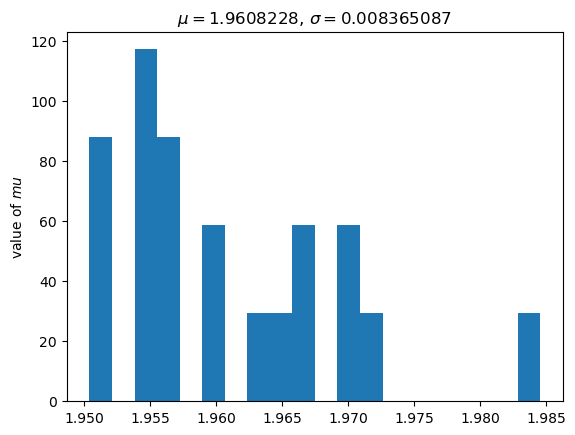

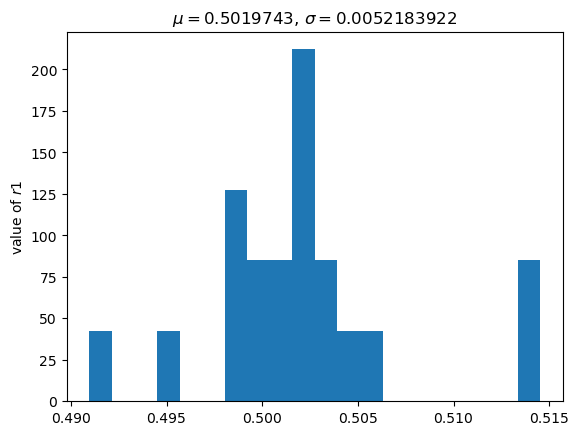

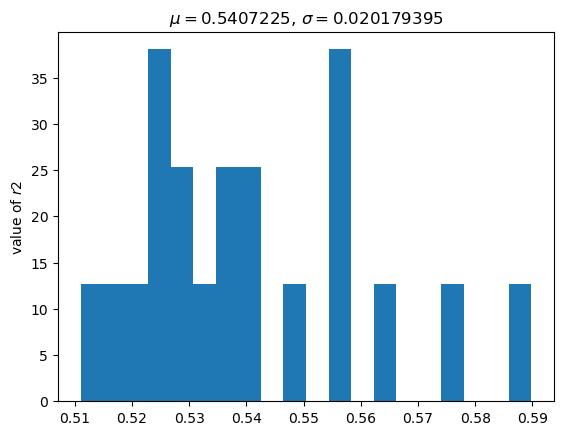

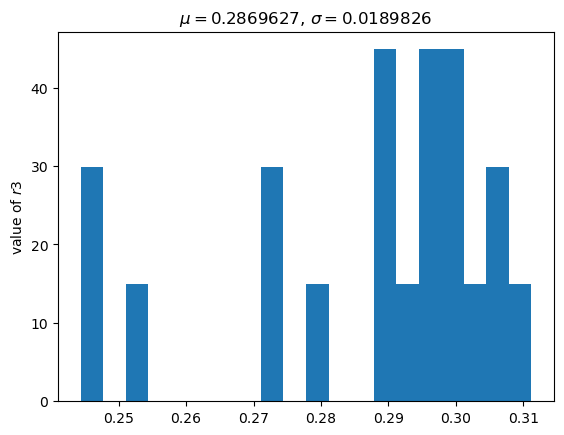

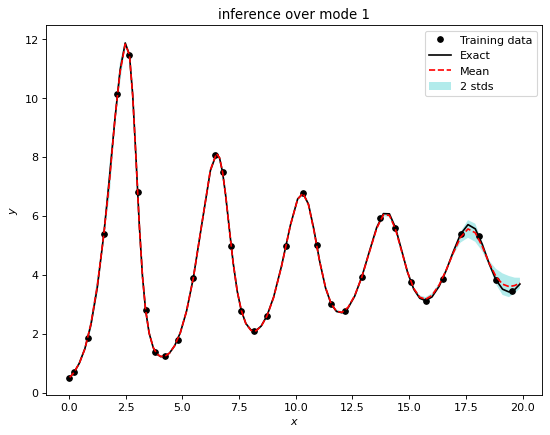

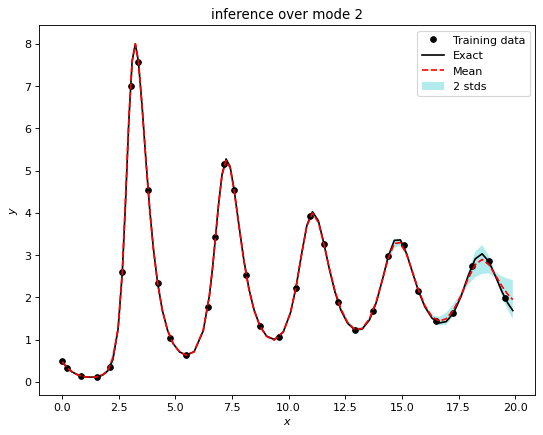

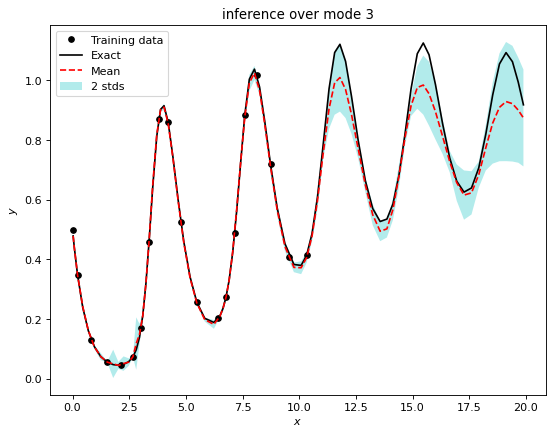

In [22]:
u_pred, mu_pred, r1_pred, r2_pred, r3_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

# NO data missing

In [23]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:, 2:3]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=3, sigma=2),
    )
    process_mu = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=1, sigma=1),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
        sigma=noise,
    )
    likelihood_u3 = neuq.likelihoods.Normal(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
        sigma=noise,
    )
    
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        pde=ode3_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=2000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))
    
    processes = [process_u, process_mu, process_r1, process_r2, process_r3]

    return processes, samples, model

@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:, 2:3]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_mu = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
    )
    likelihood_u3 = neuq.likelihoods.MSE(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
    )
    
    likelihood_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        pde=ode3_fn,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_mu, process_r1, process_r2, process_r3],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_mu, process_r1, process_r2, process_r3]
    return processes, samples, model

################## Load data and specify some hyperparameters ####################
t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test = load_data_inv()

layers = [1, 50, 50, 3]

In [24]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u2_train = u_train[:,0:1], u_train[:,1:2]  # training data
    t_u3_train = t_u_train[:]
    u3_train = u_train[:, 2:3]

    neuq.utils.hist(mu_pred, name="value of $mu$")
    neuq.utils.hist(r1_pred, name=r"value of $\theta_{11}$")
    neuq.utils.hist(r2_pred, name=r"value of $\theta_{12}$")
    neuq.utils.hist(r3_pred, name=r"value of $\theta_{21}$")
    
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_u_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
    )
    neuq.utils.plot1d(
        t_u3_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
    )

In [25]:
############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

#processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.629 

Execution time for 'Samplable' function is: 767.020 s, 12.784 mins


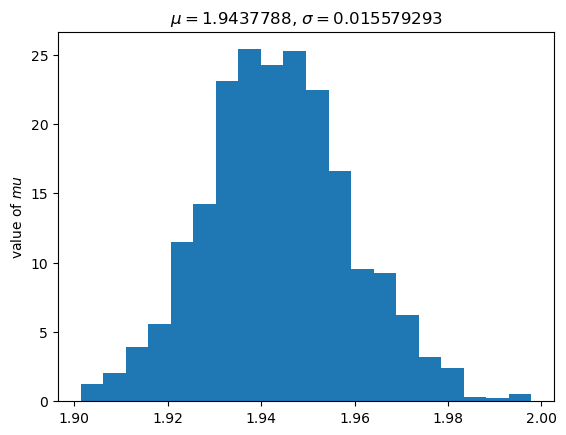

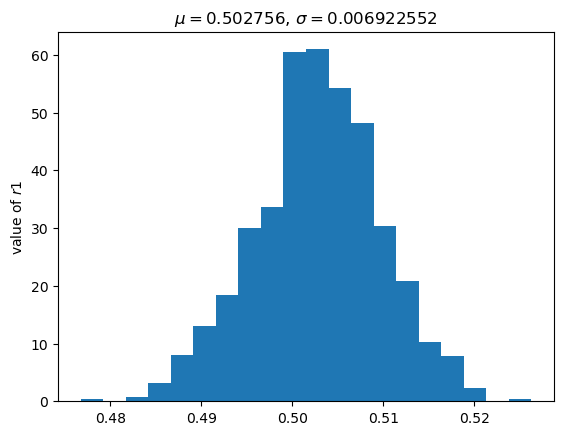

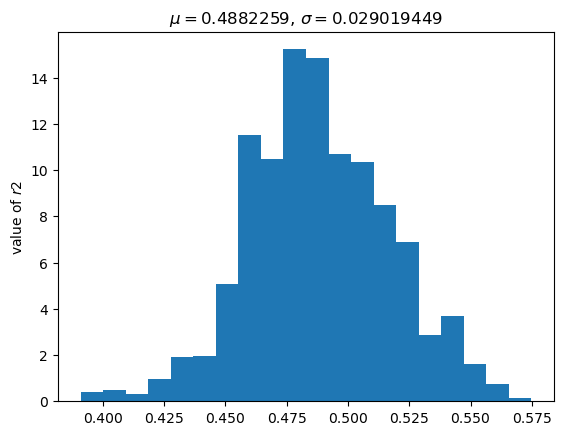

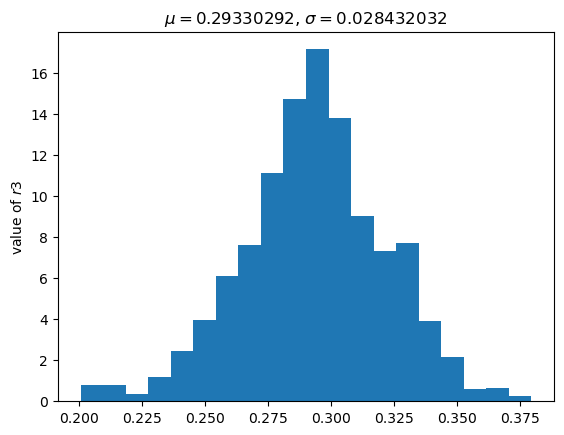

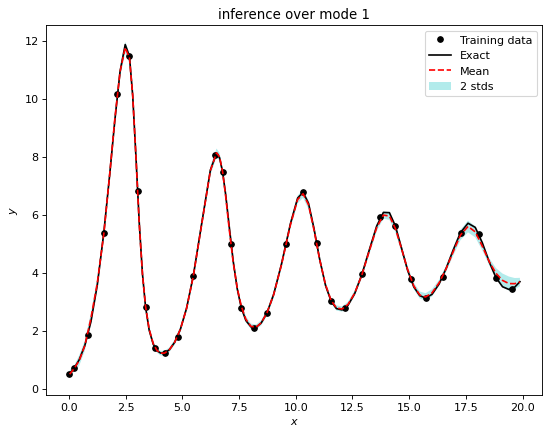

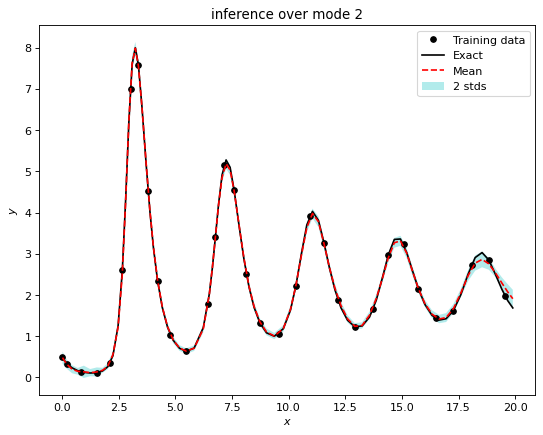

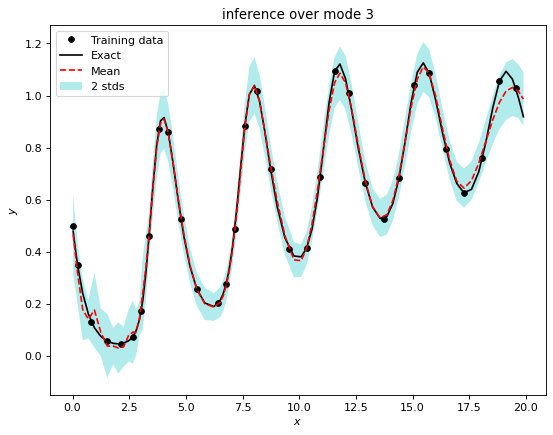

In [26]:
u_pred, mu_pred, r1_pred, r2_pred, r3_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

In [27]:
############################### Choose framework #################################
#processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  19.329926
Iteration:  100 , loss:  6.915233
Iteration:  200 , loss:  6.566116
Iteration:  300 , loss:  6.435167
Iteration:  400 , loss:  6.307262
Iteration:  500 , loss:  6.101979
Iteration:  600 , loss:  5.714556
Iteration:  700 , loss:  5.123177
Iteration:  800 , loss:  4.517063
Iteration:  900 , loss:  3.9800541
Iteration:  1000 , loss:  3.4738445
Iteration:  1100 , loss:  2.9947002
Iteration:  1200 , loss:  2.6001544
Iteration:  1300 , loss:  2.2689197
Iteration:  1400 , loss:  1.9934547
Iteration:  1500 , loss:  1.7788628
Iteration:  1600 , loss:  1.6159676
Iteration:  1700 , loss:  1.4902254
Iteration:  1800 , loss:  1.3921701
Iteration:  1900 , loss:  1.3081671
Iteration:  2000 , loss:  1.2222177
Iteration:  2100 , loss:  1.1345944
Iteration:  2200 , loss:  1.0594732
Iteration:  2300 , loss:  0.99644905
Iteration:  2400 , loss:  0.93883115
Iterat

Iteration:  1500 , loss:  1.6900826
Iteration:  1600 , loss:  1.5573993
Iteration:  1700 , loss:  1.4652859
Iteration:  1800 , loss:  1.3955305
Iteration:  1900 , loss:  1.3354992
Iteration:  2000 , loss:  1.2772179
Iteration:  2100 , loss:  1.2147775
Iteration:  2200 , loss:  1.14461
Iteration:  2300 , loss:  1.0591702
Iteration:  2400 , loss:  0.96815026
Iteration:  2500 , loss:  0.88096464
Iteration:  2600 , loss:  0.79833275
Iteration:  2700 , loss:  0.7270286
Iteration:  2800 , loss:  0.67196786
Iteration:  2900 , loss:  0.6333317
Iteration:  3000 , loss:  0.60666496
Iteration:  3100 , loss:  0.5865751
Iteration:  3200 , loss:  0.56970906
Iteration:  3300 , loss:  0.55456567
Iteration:  3400 , loss:  0.54054636
Iteration:  3500 , loss:  0.5275947
Iteration:  3600 , loss:  0.51573163
Iteration:  3700 , loss:  0.50332206
Iteration:  3800 , loss:  0.49011594
Iteration:  3900 , loss:  0.47477615
Iteration:  4000 , loss:  0.45814523
Iteration:  4100 , loss:  0.44211414
Iteration:  4200

Iteration:  3100 , loss:  0.466203
Iteration:  3200 , loss:  0.4465856
Iteration:  3300 , loss:  0.4237205
Iteration:  3400 , loss:  0.40120602
Iteration:  3500 , loss:  0.37995374
Iteration:  3600 , loss:  0.36021087
Iteration:  3700 , loss:  0.34093738
Iteration:  3800 , loss:  0.31835383
Iteration:  3900 , loss:  0.29401693
Iteration:  4000 , loss:  0.274464
Iteration:  4100 , loss:  0.25951755
Iteration:  4200 , loss:  0.24651791
Iteration:  4300 , loss:  0.23420542
Iteration:  4400 , loss:  0.22246604
Iteration:  4500 , loss:  0.21163715
Iteration:  4600 , loss:  0.20146674
Iteration:  4700 , loss:  0.19143812
Iteration:  4800 , loss:  0.18088001
Iteration:  4900 , loss:  0.16938134
Iteration:  5000 , loss:  0.15786114
Iteration:  5100 , loss:  0.14728929
Iteration:  5200 , loss:  0.13876452
Iteration:  5300 , loss:  0.13206887
Iteration:  5400 , loss:  0.12714157
Iteration:  5500 , loss:  0.12332865
Iteration:  5600 , loss:  0.12028283
Iteration:  5700 , loss:  0.11783445
Iterati

Iteration:  4900 , loss:  0.23191327
Iteration:  5000 , loss:  0.22680315
Iteration:  5100 , loss:  0.22073111
Iteration:  5200 , loss:  0.21411678
Iteration:  5300 , loss:  0.20708735
Iteration:  5400 , loss:  0.19756511
Iteration:  5500 , loss:  0.18559927
Iteration:  5600 , loss:  0.17208578
Iteration:  5700 , loss:  0.1589283
Iteration:  5800 , loss:  0.14921905
Iteration:  5900 , loss:  0.14259283
Iteration:  6000 , loss:  0.13443325
Iteration:  6100 , loss:  0.12800856
Iteration:  6200 , loss:  0.122464955
Iteration:  6300 , loss:  0.11805828
Iteration:  6400 , loss:  0.114930004
Iteration:  6500 , loss:  0.11158297
Iteration:  6600 , loss:  0.10888679
Iteration:  6700 , loss:  0.10591279
Iteration:  6800 , loss:  0.10179696
Iteration:  6900 , loss:  0.096799135
Iteration:  7000 , loss:  0.09071679
Iteration:  7100 , loss:  0.08319841
Iteration:  7200 , loss:  0.07397311
Iteration:  7300 , loss:  0.06462488
Iteration:  7400 , loss:  0.057410426
Iteration:  7500 , loss:  0.0524579

Iteration:  6500 , loss:  0.13925846
Iteration:  6600 , loss:  0.13515292
Iteration:  6700 , loss:  0.1270153
Iteration:  6800 , loss:  0.122501485
Iteration:  6900 , loss:  0.11628312
Iteration:  7000 , loss:  0.11048992
Iteration:  7100 , loss:  0.10445646
Iteration:  7200 , loss:  0.10442558
Iteration:  7300 , loss:  0.09414196
Iteration:  7400 , loss:  0.08856407
Iteration:  7500 , loss:  0.07480187
Iteration:  7600 , loss:  0.068433486
Iteration:  7700 , loss:  0.06362295
Iteration:  7800 , loss:  0.058866177
Iteration:  7900 , loss:  0.05420909
Iteration:  8000 , loss:  0.04985903
Iteration:  8100 , loss:  0.046056796
Iteration:  8200 , loss:  0.04300253
Iteration:  8300 , loss:  0.040560436
Iteration:  8400 , loss:  0.038891267
Iteration:  8500 , loss:  0.036779813
Iteration:  8600 , loss:  0.03537933
Iteration:  8700 , loss:  0.03379982
Iteration:  8800 , loss:  0.032474656
Iteration:  8900 , loss:  0.03125809
Iteration:  9000 , loss:  0.030438267
Iteration:  9100 , loss:  0.02

Iteration:  8000 , loss:  0.04614507
Iteration:  8100 , loss:  0.04432165
Iteration:  8200 , loss:  0.04265569
Iteration:  8300 , loss:  0.040905785
Iteration:  8400 , loss:  0.03898206
Iteration:  8500 , loss:  0.036746714
Iteration:  8600 , loss:  0.034470692
Iteration:  8700 , loss:  0.03197975
Iteration:  8800 , loss:  0.029672036
Iteration:  8900 , loss:  0.027624555
Iteration:  9000 , loss:  0.024057617
Iteration:  9100 , loss:  0.021603478
Iteration:  9200 , loss:  0.019334868
Iteration:  9300 , loss:  0.017308228
Iteration:  9400 , loss:  0.015548629
Iteration:  9500 , loss:  0.014090294
Iteration:  9600 , loss:  0.012998248
Iteration:  9700 , loss:  0.01192496
Iteration:  9800 , loss:  0.011067686
Iteration:  9900 , loss:  0.010355451
Iteration:  10000 , loss:  0.010870544
Iteration:  10100 , loss:  0.009091049
Iteration:  10200 , loss:  0.008505027
Iteration:  10300 , loss:  0.007894605
Iteration:  10400 , loss:  0.00731712
Iteration:  10500 , loss:  0.0067497427
Iteration:  

Iteration:  9500 , loss:  0.03209295
Iteration:  9600 , loss:  0.03096206
Iteration:  9700 , loss:  0.029801928
Iteration:  9800 , loss:  0.029002056
Iteration:  9900 , loss:  0.027945466
Iteration:  10000 , loss:  0.027151879
Iteration:  10100 , loss:  0.026412882
Iteration:  10200 , loss:  0.025904415
Iteration:  10300 , loss:  0.025068548
Iteration:  10400 , loss:  0.024440259
Iteration:  10500 , loss:  0.023704221
Iteration:  10600 , loss:  0.023034647
Iteration:  10700 , loss:  0.022358777
Iteration:  10800 , loss:  0.021735413
Iteration:  10900 , loss:  0.021129
Iteration:  11000 , loss:  0.021156559
Iteration:  11100 , loss:  0.020902716
Iteration:  11200 , loss:  0.019455548
Iteration:  11300 , loss:  0.018941017
Iteration:  11400 , loss:  0.018517155
Iteration:  11500 , loss:  0.017927676
Iteration:  11600 , loss:  0.01793599
Iteration:  11700 , loss:  0.01693608
Iteration:  11800 , loss:  0.016517105
Iteration:  11900 , loss:  0.015945164
Iteration:  12000 , loss:  0.01575636

Iteration:  11000 , loss:  0.01653964
Iteration:  11100 , loss:  0.016364917
Iteration:  11200 , loss:  0.016185593
Iteration:  11300 , loss:  0.016004633
Iteration:  11400 , loss:  0.015780719
Iteration:  11500 , loss:  0.015566455
Iteration:  11600 , loss:  0.0155941
Iteration:  11700 , loss:  0.015155191
Iteration:  11800 , loss:  0.014888619
Iteration:  11900 , loss:  0.015340604
Iteration:  12000 , loss:  0.01457158
Iteration:  12100 , loss:  0.014309544
Iteration:  12200 , loss:  0.014068135
Iteration:  12300 , loss:  0.013894284
Iteration:  12400 , loss:  0.013799363
Iteration:  12500 , loss:  0.013666831
Iteration:  12600 , loss:  0.013331679
Iteration:  12700 , loss:  0.013057275
Iteration:  12800 , loss:  0.013210602
Iteration:  12900 , loss:  0.012626915
Iteration:  13000 , loss:  0.0124130715
Iteration:  13100 , loss:  0.012190526
Iteration:  13200 , loss:  0.011963817
Iteration:  13300 , loss:  0.011731886
Iteration:  13400 , loss:  0.011901736
Iteration:  13500 , loss:  0

Iteration:  12600 , loss:  0.0094497735
Iteration:  12700 , loss:  0.008853351
Iteration:  12800 , loss:  0.008326871
Iteration:  12900 , loss:  0.0078656105
Iteration:  13000 , loss:  0.00795366
Iteration:  13100 , loss:  0.0070910854
Iteration:  13200 , loss:  0.0073979893
Iteration:  13300 , loss:  0.006457323
Iteration:  13400 , loss:  0.006432904
Iteration:  13500 , loss:  0.0059176036
Iteration:  13600 , loss:  0.0056582843
Iteration:  13700 , loss:  0.0055366186
Iteration:  13800 , loss:  0.005990515
Iteration:  13900 , loss:  0.005100294
Iteration:  14000 , loss:  0.004935627
Iteration:  14100 , loss:  0.0046312036
Iteration:  14200 , loss:  0.0044229086
Iteration:  14300 , loss:  0.0043581757
Iteration:  14400 , loss:  0.0040816157
Iteration:  14500 , loss:  0.0039235875
Iteration:  14600 , loss:  0.0037748597
Iteration:  14700 , loss:  0.003855483
Iteration:  14800 , loss:  0.0034996488
Iteration:  14900 , loss:  0.0033751142
Iteration:  15000 , loss:  0.0033044296
Iteration:

Iteration:  14100 , loss:  0.012052403
Iteration:  14200 , loss:  0.012187798
Iteration:  14300 , loss:  0.011767075
Iteration:  14400 , loss:  0.011658018
Iteration:  14500 , loss:  0.011541058
Iteration:  14600 , loss:  0.011799621
Iteration:  14700 , loss:  0.011334543
Iteration:  14800 , loss:  0.0114880465
Iteration:  14900 , loss:  0.011096726
Iteration:  15000 , loss:  0.01104773
Iteration:  15100 , loss:  0.011288331
Iteration:  15200 , loss:  0.010787938
Iteration:  15300 , loss:  0.010689487
Iteration:  15400 , loss:  0.010591337
Iteration:  15500 , loss:  0.010513736
Iteration:  15600 , loss:  0.010396186
Iteration:  15700 , loss:  0.010300568
Iteration:  15800 , loss:  0.0102162445
Iteration:  15900 , loss:  0.010112812
Iteration:  16000 , loss:  0.010021851
Iteration:  16100 , loss:  0.009964576
Iteration:  16200 , loss:  0.009837511
Iteration:  16300 , loss:  0.010464832
Iteration:  16400 , loss:  0.009869831
Iteration:  16500 , loss:  0.009587635
Iteration:  16600 , loss

Iteration:  15700 , loss:  0.009584915
Iteration:  15800 , loss:  0.009301278
Iteration:  15900 , loss:  0.009020971
Iteration:  16000 , loss:  0.008967694
Iteration:  16100 , loss:  0.008505966
Iteration:  16200 , loss:  0.008625806
Iteration:  16300 , loss:  0.008050515
Iteration:  16400 , loss:  0.007842128
Iteration:  16500 , loss:  0.007672431
Iteration:  16600 , loss:  0.0074718674
Iteration:  16700 , loss:  0.007398639
Iteration:  16800 , loss:  0.00715903
Iteration:  16900 , loss:  0.0070184343
Iteration:  17000 , loss:  0.0068902974
Iteration:  17100 , loss:  0.0067823026
Iteration:  17200 , loss:  0.008406885
Iteration:  17300 , loss:  0.006558575
Iteration:  17400 , loss:  0.0065322067
Iteration:  17500 , loss:  0.006393457
Iteration:  17600 , loss:  0.006309202
Iteration:  17700 , loss:  0.006259731
Iteration:  17800 , loss:  0.006151044
Iteration:  17900 , loss:  0.0060887313
Iteration:  18000 , loss:  0.006024171
Iteration:  18100 , loss:  0.006369442
Iteration:  18200 , 

Iteration:  17300 , loss:  0.0077619604
Iteration:  17400 , loss:  0.0076724645
Iteration:  17500 , loss:  0.007712083
Iteration:  17600 , loss:  0.0074398597
Iteration:  17700 , loss:  0.00821255
Iteration:  17800 , loss:  0.0076001654
Iteration:  17900 , loss:  0.007131069
Iteration:  18000 , loss:  0.007032918
Iteration:  18100 , loss:  0.0071672522
Iteration:  18200 , loss:  0.0073432615
Iteration:  18300 , loss:  0.006797731
Iteration:  18400 , loss:  0.006642837
Iteration:  18500 , loss:  0.0065851
Iteration:  18600 , loss:  0.0065802247
Iteration:  18700 , loss:  0.0063781985
Iteration:  18800 , loss:  0.006409555
Iteration:  18900 , loss:  0.0063134925
Iteration:  19000 , loss:  0.0060886014
Iteration:  19100 , loss:  0.0060009076
Iteration:  19200 , loss:  0.005919356
Iteration:  19300 , loss:  0.0067594973
Iteration:  19400 , loss:  0.0061755357
Iteration:  19500 , loss:  0.005949547
Iteration:  19600 , loss:  0.0060233297
Iteration:  19700 , loss:  0.0054949224
Iteration:  1

Iteration:  18800 , loss:  0.0050095813
Iteration:  18900 , loss:  0.0046551195
Iteration:  19000 , loss:  0.0046429494
Iteration:  19100 , loss:  0.0047657103
Iteration:  19200 , loss:  0.004588389
Iteration:  19300 , loss:  0.0045791883
Iteration:  19400 , loss:  0.005871073
Iteration:  19500 , loss:  0.0054173707
Iteration:  19600 , loss:  0.0045026857
Iteration:  19700 , loss:  0.004483121
Iteration:  19800 , loss:  0.0044711004
Iteration:  19900 , loss:  0.0044542467
Generating 13th sample by deep ensemble...
Iteration:  0 , loss:  14.364609
Iteration:  100 , loss:  6.882274
Iteration:  200 , loss:  6.55369
Iteration:  300 , loss:  6.425279
Iteration:  400 , loss:  6.2912555
Iteration:  500 , loss:  6.066096
Iteration:  600 , loss:  5.606401
Iteration:  700 , loss:  4.8500776
Iteration:  800 , loss:  4.0922275
Iteration:  900 , loss:  3.4535947
Iteration:  1000 , loss:  2.9007993
Iteration:  1100 , loss:  2.445096
Iteration:  1200 , loss:  2.1012769
Iteration:  1300 , loss:  1.844

Iteration:  300 , loss:  6.4289217
Iteration:  400 , loss:  6.3008776
Iteration:  500 , loss:  6.0903
Iteration:  600 , loss:  5.6843534
Iteration:  700 , loss:  5.056312
Iteration:  800 , loss:  4.379501
Iteration:  900 , loss:  3.662141
Iteration:  1000 , loss:  3.0195196
Iteration:  1100 , loss:  2.5165634
Iteration:  1200 , loss:  2.1521244
Iteration:  1300 , loss:  1.887633
Iteration:  1400 , loss:  1.6772044
Iteration:  1500 , loss:  1.5152645
Iteration:  1600 , loss:  1.3863202
Iteration:  1700 , loss:  1.2742472
Iteration:  1800 , loss:  1.165231
Iteration:  1900 , loss:  1.06086
Iteration:  2000 , loss:  0.9632687
Iteration:  2100 , loss:  0.87220687
Iteration:  2200 , loss:  0.7899292
Iteration:  2300 , loss:  0.7166606
Iteration:  2400 , loss:  0.6597688
Iteration:  2500 , loss:  0.6208835
Iteration:  2600 , loss:  0.59544384
Iteration:  2700 , loss:  0.5790415
Iteration:  2800 , loss:  0.56433755
Iteration:  2900 , loss:  0.54713005
Iteration:  3000 , loss:  0.5315917
Itera

Iteration:  1800 , loss:  1.5367837
Iteration:  1900 , loss:  1.4685522
Iteration:  2000 , loss:  1.4147923
Iteration:  2100 , loss:  1.3684648
Iteration:  2200 , loss:  1.3250166
Iteration:  2300 , loss:  1.2785782
Iteration:  2400 , loss:  1.2248031
Iteration:  2500 , loss:  1.1642206
Iteration:  2600 , loss:  1.0975236
Iteration:  2700 , loss:  1.0248748
Iteration:  2800 , loss:  0.9547153
Iteration:  2900 , loss:  0.89168555
Iteration:  3000 , loss:  0.83054245
Iteration:  3100 , loss:  0.7705655
Iteration:  3200 , loss:  0.7132899
Iteration:  3300 , loss:  0.66290444
Iteration:  3400 , loss:  0.6251564
Iteration:  3500 , loss:  0.59994626
Iteration:  3600 , loss:  0.58298683
Iteration:  3700 , loss:  0.569986
Iteration:  3800 , loss:  0.55812514
Iteration:  3900 , loss:  0.5462854
Iteration:  4000 , loss:  0.53455704
Iteration:  4100 , loss:  0.523156
Iteration:  4200 , loss:  0.5125576
Iteration:  4300 , loss:  0.5013415
Iteration:  4400 , loss:  0.48255512
Iteration:  4500 , los

Iteration:  3700 , loss:  0.5515832
Iteration:  3800 , loss:  0.5369266
Iteration:  3900 , loss:  0.5231282
Iteration:  4000 , loss:  0.5099131
Iteration:  4100 , loss:  0.49705413
Iteration:  4200 , loss:  0.484478
Iteration:  4300 , loss:  0.47124374
Iteration:  4400 , loss:  0.45438993
Iteration:  4500 , loss:  0.434505
Iteration:  4600 , loss:  0.41173378
Iteration:  4700 , loss:  0.38346282
Iteration:  4800 , loss:  0.35782197
Iteration:  4900 , loss:  0.33255115
Iteration:  5000 , loss:  0.30696744
Iteration:  5100 , loss:  0.28621522
Iteration:  5200 , loss:  0.27100965
Iteration:  5300 , loss:  0.25994116
Iteration:  5400 , loss:  0.2520473
Iteration:  5500 , loss:  0.24665537
Iteration:  5600 , loss:  0.24071369
Iteration:  5700 , loss:  0.2335536
Iteration:  5800 , loss:  0.22487068
Iteration:  5900 , loss:  0.21608591
Iteration:  6000 , loss:  0.20807217
Iteration:  6100 , loss:  0.20074536
Iteration:  6200 , loss:  0.1935587
Iteration:  6300 , loss:  0.1857796
Iteration:  6

Iteration:  5400 , loss:  0.30025807
Iteration:  5500 , loss:  0.2904574
Iteration:  5600 , loss:  0.28196275
Iteration:  5700 , loss:  0.27234223
Iteration:  5800 , loss:  0.26396903
Iteration:  5900 , loss:  0.25627077
Iteration:  6000 , loss:  0.24998839
Iteration:  6100 , loss:  0.24519204
Iteration:  6200 , loss:  0.2421654
Iteration:  6300 , loss:  0.23922138
Iteration:  6400 , loss:  0.23748738
Iteration:  6500 , loss:  0.23601381
Iteration:  6600 , loss:  0.23494172
Iteration:  6700 , loss:  0.23409605
Iteration:  6800 , loss:  0.23338023
Iteration:  6900 , loss:  0.23301253
Iteration:  7000 , loss:  0.23218155
Iteration:  7100 , loss:  0.2317484
Iteration:  7200 , loss:  0.23120274
Iteration:  7300 , loss:  0.23085606
Iteration:  7400 , loss:  0.23033093
Iteration:  7500 , loss:  0.22990927
Iteration:  7600 , loss:  0.22947335
Iteration:  7700 , loss:  0.22903189
Iteration:  7800 , loss:  0.22844665
Iteration:  7900 , loss:  0.22787622
Iteration:  8000 , loss:  0.2269653
Itera

Iteration:  7200 , loss:  0.06478669
Iteration:  7300 , loss:  0.062429376
Iteration:  7400 , loss:  0.060504854
Iteration:  7500 , loss:  0.058139626
Iteration:  7600 , loss:  0.056219842
Iteration:  7700 , loss:  0.054229885
Iteration:  7800 , loss:  0.052462634
Iteration:  7900 , loss:  0.05091269
Iteration:  8000 , loss:  0.049144685
Iteration:  8100 , loss:  0.04773111
Iteration:  8200 , loss:  0.046442993
Iteration:  8300 , loss:  0.045300595
Iteration:  8400 , loss:  0.04434145
Iteration:  8500 , loss:  0.043342706
Iteration:  8600 , loss:  0.042786703
Iteration:  8700 , loss:  0.04174193
Iteration:  8800 , loss:  0.041064475
Iteration:  8900 , loss:  0.04059506
Iteration:  9000 , loss:  0.039867047
Iteration:  9100 , loss:  0.039331127
Iteration:  9200 , loss:  0.038843438
Iteration:  9300 , loss:  0.038378164
Iteration:  9400 , loss:  0.037947834
Iteration:  9500 , loss:  0.037536625
Iteration:  9600 , loss:  0.03716454
Iteration:  9700 , loss:  0.03680507
Iteration:  9800 , l

Iteration:  8800 , loss:  0.058605567
Iteration:  8900 , loss:  0.057733443
Iteration:  9000 , loss:  0.056936037
Iteration:  9100 , loss:  0.05639606
Iteration:  9200 , loss:  0.055591073
Iteration:  9300 , loss:  0.05506752
Iteration:  9400 , loss:  0.054467015
Iteration:  9500 , loss:  0.05384549
Iteration:  9600 , loss:  0.053359788
Iteration:  9700 , loss:  0.05286731
Iteration:  9800 , loss:  0.05257645
Iteration:  9900 , loss:  0.052042514
Iteration:  10000 , loss:  0.051830288
Iteration:  10100 , loss:  0.051284987
Iteration:  10200 , loss:  0.050934646
Iteration:  10300 , loss:  0.050610572
Iteration:  10400 , loss:  0.050304875
Iteration:  10500 , loss:  0.05002026
Iteration:  10600 , loss:  0.049798127
Iteration:  10700 , loss:  0.049481813
Iteration:  10800 , loss:  0.049309198
Iteration:  10900 , loss:  0.04897927
Iteration:  11000 , loss:  0.048744787
Iteration:  11100 , loss:  0.04853022
Iteration:  11200 , loss:  0.048324864
Iteration:  11300 , loss:  0.048198074
Iterat

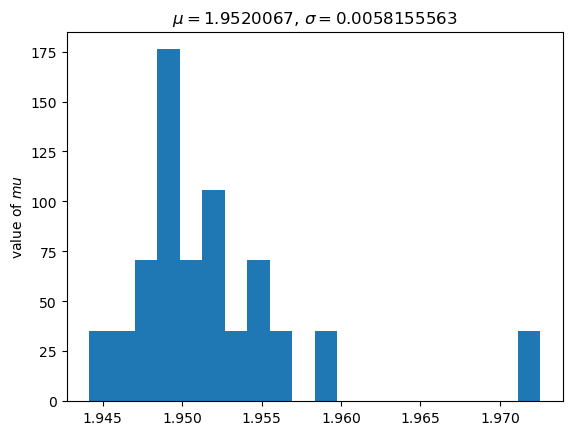

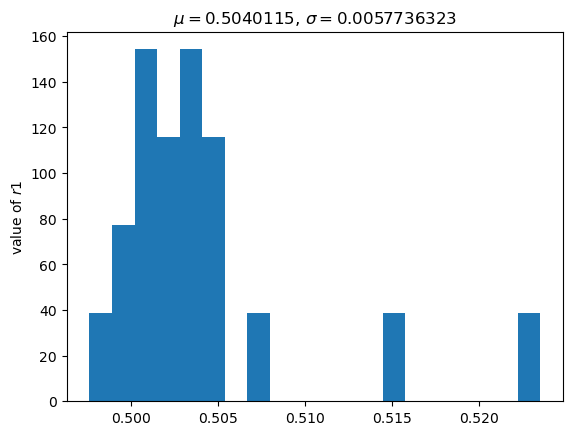

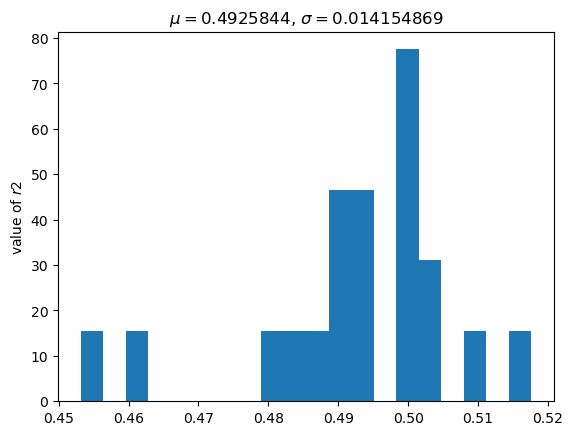

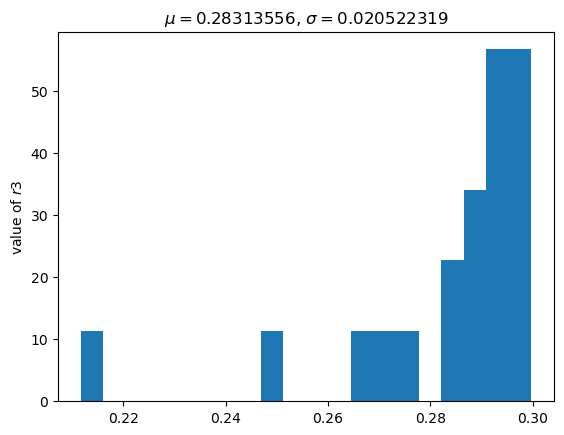

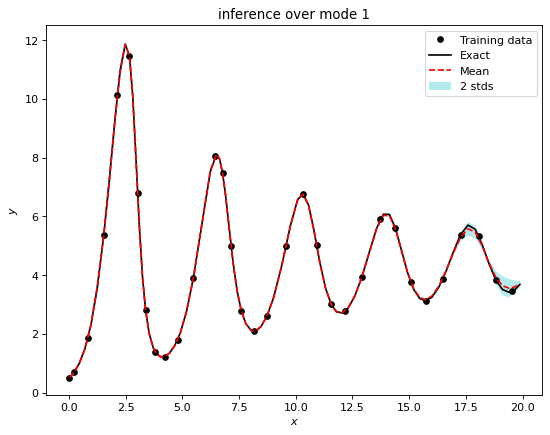

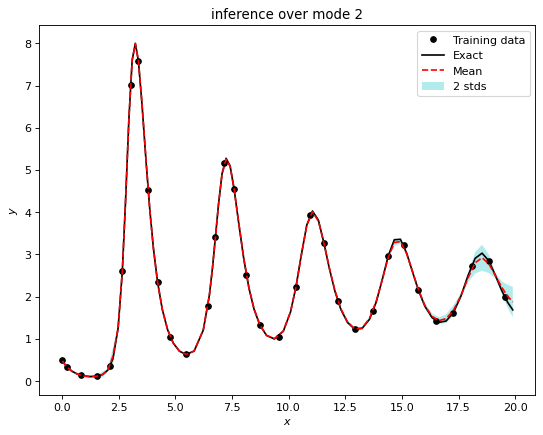

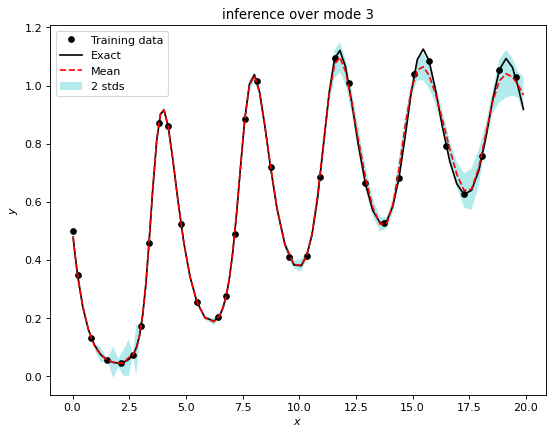

In [28]:
u_pred, mu_pred, r1_pred, r2_pred, r3_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

# Forward 

In [ ]:
def pde_fn(x, u):
    mu = 1.95
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t, u2_t, u3_t = tf.gradients(u1,x)[0], tf.gradients(u2,x)[0], tf.gradients(u3,x)[0]
    
    f1 = u1_t - u1*(mu - 0.1*u1 -0.5*u2 -0.5*u3)
    f2 = u2_t - u2*(-mu + 0.5*u1 - 0.3*u3)
    f3 = u3_t - u3*(-mu + 0.2*u1 + 0.5*u2)
    
    return tf.concat([f1,f2, f3], axis=-1)

def load_data_for():
    data = sio.loadmat("../dataset/3_species_30.mat")
    t_test, u_test, f_test = data["t_test"][:80], data["u_test"][:80, :], data["f_test"][:80, :]
    t_u_train, u_train = data["t_train"][:33], data["u_train"][:33, :]
    t_f_train, f_train = data["t_f_train"][:40], data["f_train"][:40, :]
    
    noise = 0.1
    return t_u_train, u_train, t_f_train, f_train, t_test, u_test, f_test, noise

################## Load data and specify some hyperparameters ####################
x_u_train, u_train, x_f_train, f_train, x_test, u_test, f_test, noise = load_data_for()
layers = [1, 50, 50, 3]

####################### Build model and perform inference ########################
# All models share the same general procedure:
# Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# Step 2: build prior and/or posterior using [variables]
# Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# Step 4: build likelihood, given noisy measurements, using [likelihoods]
# Step 5: build model using [models]
# Step 6: create an inference method and assign it to the model using [inferences]
# Step 7: perform posterior sampling using [model.run]

x_u3_train = x_u_train[:20]
x_u12_train = x_u_train
u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]

process = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    prior=neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1),
)
likelihood_u12 = neuq.likelihoods.Normal(
    inputs=x_u_train,
    targets=np.concatenate([u1_train, u2_train], axis=-1),
    processes=[process],
    out_dims=[[0, 1]],
    pde=None,
    sigma=noise,
)
likelihood_u3 = neuq.likelihoods.Normal(
    inputs=x_u3_train,
    targets=u3_train,
    processes=[process],
    out_dims=[[2]],
    pde=None,
    sigma=noise,
)
likelihood_f = neuq.likelihoods.Normal(
    inputs=x_f_train,
    targets=f_train,
    processes=[process],
    pde=pde_fn,
    sigma=noise,
)

model = neuq.models.Model(
    processes=[process],
    likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
)
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=6666,
)
model.compile(method)
samples, results = model.run()
print("Acceptance rate: %.3f \n"%(np.mean(results)))  # if HMC is used

################################# Predictions ####################################
(u_pred,) = model.predict(x_test, samples, processes=[process])
(f_pred,) = model.predict(x_test, samples, processes=[process], pde_fn=pde_fn)



In [ ]:
############################### Postprocessing ###################################
neuq.utils.plot1d(x_u_train, u_train[:,0], x_test, u_test[:,0:1], u_pred[:,:,0])
neuq.utils.plot1d(x_u_train, u_train[:,1], x_test, u_test[:,1:2], u_pred[:,:,1])
neuq.utils.plot1d(x_u_train[:20], u_train[:20,2], x_test, u_test[:,2:3], u_pred[:,:,2])

### Forward Trainable

In [ ]:
x_u_train, u_train, x_f_train, f_train, x_test, u_test, f_test, noise = load_data_for()
layers = [1, 50, 50, 3]

x_u3_train = x_u_train[:20]
u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]

# build processes
process_u = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    posterior=neuq_vars.fnn.Trainable(
        layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
    ),
)


# build likelihood
likelihood_u12 = neuq.likelihoods.MSE(
    inputs=x_u_train,
    targets=np.concatenate([u1_train, u2_train], axis=-1),
    processes=[process_u],
    out_dims=[[0, 1]],
)
likelihood_u3 = neuq.likelihoods.MSE(
    inputs=x_u3_train,
    targets=u3_train,
    processes=[process_u],
    out_dims=[[2]],
)

likelihood_f = neuq.likelihoods.MSE(
    inputs=x_f_train,
    targets=f_train,
    processes=[process_u],
    pde=pde_fn,
)
# build model
model = neuq.models.Model(
    processes=[process_u],
    likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
)
# assign and compile method
method = neuq.inferences.DEns(
    num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
)
model.compile(method)
# obtain posterior samples
samples = model.run()
samples = neuq.utils.batch_samples(samples)  # reshape

processes = [process_u]

In [ ]:
(u_pred,) = model.predict(x_test, samples, processes)
(f_pred,) = model.predict(x_test, samples, processes, pde_fn=pde_fn)

In [ ]:
neuq.utils.plot1d(x_u_train, u_train[:,0], x_test, u_test[:,0:1], u_pred[:,:,0])
neuq.utils.plot1d(x_u_train, u_train[:,1], x_test, u_test[:,1:2], u_pred[:,:,1])
neuq.utils.plot1d(x_u_train[:20], u_train[:20,2], x_test, u_test[:,2:3], u_pred[:,:,2])